# NHL Expected Goals Model

This notebook will look to create a predictive model using xGBoost to predict the liklihood of a goal occuring on a shot. Using data from 10 NHL seasons, I will look to emulate EvolvingWild's xGoal model using Polars and Pandas (rather than R). I want to give them full credit for the idea of building this model. Their model was built out in R and I wanted to better my skills using Polars, Pandas, and Python using their methodology. I also want to credit Evolving Wild with their incredible ability to pique my interest in building a model of this sort as they are wonderful content creators and ask/answer great questions from the NHL analytic community. The methodology of building this model is heavily based on thier methodology (with some additions from myself) and I do not want to take credit for their work without seriously crediting them. This notebook is essentially a way for me to better my skills in different languages and should be considered a translation of their model from R into Python.


Please read their fantastic article [here](https://evolving-hockey.com/blog/a-new-expected-goals-model-for-predicting-goals-in-the-nhl/) to learn more about their methodology.

In [49]:
# Pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Polars
import polars as pl
pl.Config.set_tbl_rows(n=-1)
pl.Config.set_tbl_cols(n=-1)


# General
from math import pi
import time

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# Modeling
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, accuracy_score, roc_curve, roc_auc_score, auc, make_scorer, precision_score, recall_score, log_loss, f1_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

# HyperTuning
import optuna
from optuna.samplers import TPESampler

# Save
import pickle

# 1) Load NHL Play By Play Data

Here, I will create 3 functions to help clean and tweak play-by-play data that will be sourced from the NHL API and loaded as a Polars DF with the help of SportsDataVerse. Learn more about SportsDataVerse [here](https://sportsdataverse-py.sportsdataverse.org/docs/nhl/).

## *a) Identify Constants (Keys for Events, Game States and Rosters)*

In [50]:
### Event Type Classification ###
xG_Events = ['GOAL', 'SHOT', 'MISSED_SHOT', 'BLOCKED_SHOT', 'FACEOFF', 'TAKEAWAY', 'GIVEAWAY', 'HIT']
fenwick_events = ['SHOT', 'GOAL', 'MISSED_SHOT']
corsi_events = ['SHOT', 'GOAL', 'MISSED_SHOT', 'BLOCKED_SHOT']

# Strength States
EV_STR_Codes = ['5v5', '4v4', '3v3']
PP_STR_Codes = ["5v4", "4v5", "5v3", "3v5", "4v3", "3v4"]
UE_STR_Codes = ["5v4", "4v5", "5v3", "3v5", "4v3", "3v4", "5vE", "Ev5", "4vE", "Ev4", "3vE", "Ev3"]
SH_STR_Codes = ['5v6', '4v5', '3v4', '4v6']

In [51]:
# Load Rosters
roster_file = 'https://raw.githubusercontent.com/twinfield10/NHL-Data/main/Rosters/parquet/all/NHL_Roster_AllSeasons_Slim.parquet'
ROSTER_DF_RAW = pl.read_parquet(roster_file)
ROSTER_DF = (
    ROSTER_DF_RAW
    .rename({"player_id": "event_player_1_id"})
    .with_columns([
        pl.col("event_player_1_id").cast(pl.Utf8),
        pl.when((pl.col('pos_F') == 0) & (pl.col('pos_G') == 0)).then(pl.lit(1)).otherwise(pl.lit(0)).alias('pos_D')
        ])
    .select(['event_player_1_id', 'hand_R', 'hand_L', 'pos_F', 'pos_D', 'pos_G'])
    .unique()
)

# Create Goalie DF
GOALIES = (
    ROSTER_DF_RAW
    .filter(pl.col('pos_G') == 1)
    .with_columns([pl.col("player_id").cast(pl.Utf8)])
    .select('player_id','hand_R', 'hand_L')
)
GOALIES.columns = ['event_goalie_id', 'G_hand_R', 'G_hand_L']

In [52]:
GOALIES.head()

event_goalie_id,G_hand_R,G_hand_L
str,i32,i32
"""8480591""",0,1
"""8471403""",0,1
"""8460704""",0,1
"""8474682""",0,1
"""8475622""",0,1


## *b) Function: Spatial Normalization and Feature Creation*

- First, I want to clean some of the spatial data. NHL API uses "x_fixed" and "y_fixed" to locate events.
    - x_fixed and y_fixed are cooridates that are "fixed" from perspective of the home team.
    - Since this is an expected goals model, I want the frame of reference to e the location of the event from how far away the event is from the goal of the attacking taem.
- Then I continue to clean and create metrics for the shot distance and angle.
- I also add in some clean classifications for which zone the events occured in
- Finally, we classify penalty shots as their own "game state"

In [53]:
def clean_pbp_data(data):
    """ This function will use inputs from play-by-play data to build usable features in a model.
    Notes:
        1) x_fixed and y_fixed are independent of period and remain constant (Home attacking zone is x_fixed > 0 and Away attacking zone is y_fixed < 0)
        2) Neutral Zone calculation assumes that x coord is > abs(25). >= abs(25) is considered OZ and DZ
    """
    ### EVENT CALCULATIONS ###

    # 1) Create Columns Relative To Event Team
    data = data.with_columns([
        pl.when(pl.col('event_team_id') == pl.col('away_id')).then(pl.col('away_abbreviation'))
          .when(pl.col('event_team_id') == pl.col('home_id')).then(pl.col('home_abbreviation'))
          .otherwise(pl.lit(None)).alias('event_team')
      ])
    # 2) Create Zones Using Coordinates
    data = data.with_columns(
      [
        pl.when(data['x_abs'] >= 25).then(pl.lit('OZ'))
        .when((data['x_abs'] > -25) & (data['x_abs'] < 25)).then(pl.lit('NZ'))
        .when(data['x_abs'] <= -25).then(pl.lit('DZ'))
        .otherwise(None)
        .alias('event_zone')
      ]
    )

    data = data.with_columns(
      [
        pl.when((data['event_zone'] == 'OZ') & (data['event_team_type'] == 'home')).then(pl.lit('OZ'))
        .when((data['event_zone'] == 'OZ') & (data['event_team_type'] == 'away')).then(pl.lit('DZ'))
        .when((data['event_zone'] == 'DZ') & (data['event_team_type'] == 'home')).then(pl.lit('DZ'))
        .when((data['event_zone'] == 'DZ') & (data['event_team_type'] == 'away')).then(pl.lit('OZ'))
        .when((data['event_zone'] == 'NZ')).then(pl.lit('NZ'))
        .otherwise(None)
        .alias('home_event_zone')
      ]
    )
    # 3) Create Event Distance Calculation
    data = (
        data
        .with_columns([
          pl.when(data['x_abs'] >= 0).then(pl.Series.sqrt((89.25 - pl.Series.abs(data['x_abs']))**2 + data['y_abs']**2))
          .when(data['x_abs'] <  0).then(pl.Series.sqrt((pl.Series.abs(data['x_abs']) + 89.25)**2 + data['y_abs']**2))
          .alias('event_distance')
        ])
        .with_columns([
            pl.when((pl.col('event_distance').abs() == 0.0)).then(pl.lit(0.25))
            .otherwise(pl.col('event_distance').round(3)).alias('event_distance')
        ])
    )
    # 4) Create Event Angle Calculation
    data = (
        data
        .with_columns(
        pl.when(data['x_abs'] >= 0)
          .then(pl.Series.arctan(data['y_abs'] / (89.25 - pl.Series.abs(data['x_abs'])))
                .map_elements(lambda x: abs(x * (180 / pi))))
          .when(data['x_abs'] < 0)
          .then(pl.Series.arctan(data['y_abs'] / (pl.Series.abs(data['x_abs']) + 89.25))
                .map_elements(lambda x: abs(x * (180 / pi))))
          .alias('event_angle')
        )
        .with_columns(
            pl.when(pl.col('x_abs') > 89.25).then((180 - pl.col('event_angle'))).otherwise(pl.col('event_angle')).alias('event_angle')
        )
        .with_columns(
            pl.col('event_angle').round(3)
        )
    )
    # 5) Adjust Penalty Shot Game State
    data = data.with_columns(
        [
            pl.when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'home')
            ).then(pl.lit('Ev1'))
            .when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'away')
            ).then(pl.lit('1vE'))
            .otherwise(data['strength_state']).alias('strength_state'),

            pl.when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'home')
            ).then(pl.lit(1))
            .when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'away')
            ).then(pl.lit(0))
            .otherwise(data['home_skaters']).alias('home_skaters'),

            pl.when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'home')
            ).then(pl.lit(0))
            .when(
                (data['secondary_type'] == 'Penalty Shot') &
                (data['event_team_type'] == 'away')
            ).then(pl.lit(1))
            .otherwise(data['away_skaters']).alias('away_skaters')
        ]
    )

    ### END EVENT CALCULATION ###
    return data

## *c) Function: Indexing Operations*

- Now that we have some cleaner data, I want to build some indexes to help organize the play by play data to create time variables used in the model.
- We look to create an index for:
    - Faceoffs
        - *Also used to create which zone in which a play started.*
    - Shifts
    - Penalties
- These indexes will help us to create model features related to time relative to when events occured previously.

In [54]:
def index_input_data(data):
    """ This Function will create indexes and ID's for certain types of plays/events."""

    # 1) Add Zone Start For Corsi Events (i.e., shots)
    #fc_idx = (
    #    data
    #    .filter((pl.col('event_type').is_in(['FACEOFF'] + xG_Events)) &
    #    (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P'))
    #    )
    #    .sort('game_id', 'period', 'event_idx')
    #    .with_columns(pl.when(pl.col('event_type') == "FACEOFF").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_fac'))
    #    .with_columns(pl.col('is_fac').cum_sum().alias('face_index'))
    #    .select(['game_id', 'event_idx', 'face_index', 'home_zone'])
    #    .sort('game_id', 'event_idx', 'face_index')
    #    .with_columns(pl.col('home_zone').first().over(['game_id', 'face_index']).alias('first_home_zone'))
    #    .with_columns(
    #        pl.when(pl.first('first_home_zone') == 'OZ').then(1)
    #        .when(pl.first('first_home_zone') == 'NZ').then(2)
    #        .when(pl.first('first_home_zone') == 'DZ').then(3)
    #        .otherwise(pl.lit(None))
    #        .alias('home_zonestart')
    #    )
    #    .select(['game_id', 'event_idx', 'home_zonestart'])
    #)
    #data = data.join(fc_idx, on=["game_id", "event_idx"], how="left")


    # 2) Create Indexes For Shift and Penalties
    home_player_id_col_struct = ["home_1_on_id", "home_2_on_id", "home_3_on_id", "home_4_on_id", "home_5_on_id", "home_6_on_id", "home_goalie"]
    away_player_id_col_struct = ["away_1_on_id", "away_2_on_id", "away_3_on_id", "away_4_on_id", "away_5_on_id", "away_6_on_id", "away_goalie"]
    all_player_id_col_struct = home_player_id_col_struct + away_player_id_col_struct

    data = (
        data
        .sort(["season","game_id", "period", "event_idx"])
        .with_columns([
            pl.when(pl.col("event_type") == "FACEOFF").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_fac'),
            pl.when(pl.col("event_type") == "PENALTY").then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_pen'),
            pl.when((pl.struct(all_player_id_col_struct) != pl.struct(all_player_id_col_struct).shift()) | (pl.col('event_type').shift() == 'PERIOD_START')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_shi'),
            pl.when((pl.struct(home_player_id_col_struct) != pl.struct(home_player_id_col_struct).shift()) | (pl.col('event_type').shift() == 'PERIOD_START')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_H_shi'),
            pl.when((pl.struct(away_player_id_col_struct) != pl.struct(away_player_id_col_struct).shift()) | (pl.col('event_type').shift() == 'PERIOD_START')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_A_shi'),
          ])
        .with_columns([
            pl.col('is_fac').cum_sum().alias('face_index'),
            pl.col('is_pen').cum_sum().alias('pen_index'),
            pl.col('is_shi').cum_sum().alias('all_shift_index'),
            pl.col('is_H_shi').cum_sum().alias('home_shift_index'),
            pl.col('is_A_shi').cum_sum().alias('away_shift_index'),
        ])
        .sort('season', 'game_id', 'event_idx')
        .with_columns([
            (pl.col('game_seconds').first().over(["season","game_id", "period", "all_shift_index"])).alias("all_shift_start_seconds"),
            (pl.col('game_seconds').last().over(["season","game_id", "period", "all_shift_index"])).alias("all_shift_end_seconds"),
            (pl.col('game_seconds').first().over(["season","game_id", "period", "home_shift_index"])).alias("home_shift_start_seconds"),
            (pl.col('game_seconds').last().over(["season","game_id", "period", "home_shift_index"])).alias("home_shift_end_seconds"),
            (pl.col('game_seconds').first().over(["season","game_id", "period", "away_shift_index"])).alias("away_shift_start_seconds"),
            (pl.col('game_seconds').last().over(["season","game_id", "period", "away_shift_index"])).alias("away_shift_end_seconds")
            ])
        .drop(['is_fac', 'is_shi', 'is_pen', 'is_H_shi', 'is_A_shi'])
        )


    gb_cols_1 = ["game_id", "period", "face_index", "pen_index"]

    idx_df = (
        data
        .filter(
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P'))
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            pl.when(pl.struct(gb_cols_1 + ['all_shift_index']) != pl.struct(gb_cols_1 + ['all_shift_index']).shift()).then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_all_new_shift'),
            pl.when(pl.struct(["game_id", "period",'home_shift_index']) != pl.struct(["game_id", "period",'home_shift_index']).shift()).then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_home_new_shift'),
            pl.when(pl.struct(["game_id", "period",'away_shift_index']) != pl.struct(["game_id", "period",'away_shift_index']).shift()).then(pl.lit(1)).otherwise(pl.lit(0)).alias('is_away_new_shift'),
                   ])
        .with_columns([
            pl.col('is_all_new_shift').cum_sum().alias('all_shift_ID'),
            pl.col('is_home_new_shift').cum_sum().alias('home_shift_ID'),
            pl.col('is_away_new_shift').cum_sum().alias('away_shift_ID')
        ])
        .with_columns([
            (pl.col('game_seconds') - pl.col('all_shift_start_seconds')).alias('all_shift_length'),
            (pl.col('game_seconds') - pl.col('home_shift_start_seconds')).alias('home_shift_length'),
            (pl.col('game_seconds') - pl.col('away_shift_start_seconds')).alias('away_shift_length')
        ])
        .with_columns([
            pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_shift_length'))
              .when(pl.col('event_team_type') == 'away').then(pl.col('away_shift_length'))
              .otherwise(None).alias('event_team_toi'),
            pl.when(pl.col('event_team_type') == 'away').then(pl.col('home_shift_length'))
              .when(pl.col('event_team_type') == 'home').then(pl.col('away_shift_length'))
              .otherwise(None).alias('def_team_toi'),
            pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_shift_length') - pl.col('away_shift_length'))
              .when(pl.col('event_team_type') == 'away').then(pl.col('away_shift_length') - pl.col('home_shift_length'))
              .otherwise(None).alias('event_team_shift_time_diff')
        ])
        .select("game_id", "period", "event_idx", "face_index", "all_shift_index", "home_shift_index", "away_shift_index", "pen_index",
                "all_shift_ID", "home_shift_ID", "away_shift_ID",
                "all_shift_length", "home_shift_length", "away_shift_length")
    )

    # Join Indexes To Data (Join All Common Columns)
    idx_cols = idx_df.columns
    data_cols = data.columns
    common_cols = list(set(idx_cols) & set(data_cols))

    data =  data.join(
             idx_df,
             on=common_cols,
             how="left"
         )

    return data

# *d) Function: Separate Data by Game Strength Stae*

Here I am following Evolving Wild's method of splitting data into 4 dataframes to build 4 models for 4 game states:
- Even Strength (5v5, 4v4, 3v3)
- Power-Play/Unequal Advantage (6v5, 6v4, 5v4, 5v3, 4v3)
- Short-Handed (4v5, 3v5, 3v4)
- Empty Net

In [55]:
def split_by_strength(data):
    """This function will split and clean indexed play-by-play data into 4 categories (EV, PP, SH, and EN)"""

    EV_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'home_shift_ID']))).alias('home_skaters_toi'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'away_shift_ID']))).alias('away_skaters_toi'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            (pl.when((pl.col('event_team_type') == 'home')).then((pl.col('home_goalie')).str.to_uppercase()).otherwise((pl.col('away_goalie').str.to_uppercase())).alias('event_goalie_id'))
        ])
        .with_columns([
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'away').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('event_team_toi'),
            (pl.when(pl.col('event_team_type') == 'away').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'home').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('def_team_toi')
        ])
        .with_columns([
            (pl.col('def_team_toi') - pl.col('event_team_toi')).alias('event_team_shift_time_diff')
        ])
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (pl.col('strength_state').is_in(EV_STR_Codes)) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            #(pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89.25 - (pl.col('x_abs_last').abs()))).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89.25)).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89.25).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select(['season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
                'strength_state', 'score_state', 'is_home', 
                'event_player_1_id', 'home_goalie', 'away_goalie', 'event_player_2_id', 'event_goalie_id',
                'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
                'event_type', 'event_team', 'event_team_abbr', 'secondary_type',
                'x_abs', 'y_abs', 'event_angle_last', 'event_angle', 'event_distance',
                'event_angle_change', 'event_angle_change_speed',
                'event_team_last', 'same_team_last', 'event_strength_last', 'event_type_last',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'])
    )

    ## Build PP DataFrame ##
    PP_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'home_shift_ID']))).alias('home_skaters_toi'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'away_shift_ID']))).alias('away_skaters_toi'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('event_angle').shift(1).over(['season', 'game_id', 'period']))).alias('event_angle_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            (pl.when(pl.col('strength_state').is_in(PP_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_pen'),
            (pl.when(((pl.col('home_skaters') - pl.col('away_skaters')) >= 2) | ((pl.col('away_skaters') - pl.col('home_skaters')) >= 2)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_two_ma'),
            (pl.when((pl.col('event_team_type') == 'home')).then((pl.col('home_goalie')).str.to_uppercase()).otherwise((pl.col('away_goalie').str.to_uppercase())).alias('event_goalie_id'))
        ])
        .with_columns(((pl.col('is_pen')) * ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'pen_index'])))).alias('pen_seconds_since'))
        .with_columns([
            (pl.when((pl.col('pen_seconds_since') > 0) & (pl.col('pen_seconds_since') >= 300)).then(pl.lit(120)).otherwise(pl.col('pen_seconds_since'))).alias('pen_seconds_since')
            ])
        .with_columns([
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'away').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('event_team_toi'),
            (pl.when(pl.col('event_team_type') == 'away').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'home').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('def_team_toi')
        ])
        .with_columns([
            (pl.col('def_team_toi') - pl.col('event_team_toi')).alias('event_team_shift_time_diff')
        ])
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (((pl.col('event_team_type') == 'home') & (pl.col('true_strength_state').is_in(["6v5", "6v4", "5v4", "5v3", "4v3"]))) |
            ((pl.col('event_team_type') == 'away') & (pl.col('true_strength_state').is_in(["5v6", "4v6", "4v5", "3v5", "3v4"])))) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            #(pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last'),
            (pl.when(pl.col('event_strength_last').is_in(EV_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_event_EV')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89.25 - (pl.col('x_abs_last').abs()))).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89.25)).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89.25).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select([
            'season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
            'strength_state', 'true_strength_state', 'score_state', 'is_home', 'is_two_ma',
            'event_player_1_id', 'home_goalie', 'away_goalie', 'event_player_2_id', 'event_goalie_id',
            'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
            'event_type', 'event_team', 'event_team_abbr', 'event_team_type', 'secondary_type',
            'x_abs', 'y_abs', 'event_angle_last', 'event_angle', 'event_distance',
            'event_angle_change', 'event_angle_change_speed',
            'event_team_last', 'same_team_last', 'event_strength_last', 'prior_event_EV', 'event_type_last',
            'seconds_since_last', 'pen_seconds_since', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
            'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'
        ])
    )

    ## Build SH DataFrame ##
    SH_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'home_shift_ID']))).alias('home_skaters_toi'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'away_shift_ID']))).alias('away_skaters_toi'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('event_angle').shift(1).over(['season', 'game_id', 'period']))).alias('event_angle_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            (pl.concat_str([pl.col('home_skaters'), pl.lit('v'), pl.col('away_skaters')])).alias('true_strength_state'),
            (pl.when(pl.col('strength_state').is_in(PP_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_pen'),
            (pl.when(((pl.col('home_skaters') - pl.col('away_skaters')) >= 2) | ((pl.col('away_skaters') - pl.col('home_skaters')) >= 2)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_two_ma'),
            (pl.when((pl.col('event_team_type') == 'home')).then((pl.col('home_goalie')).str.to_uppercase()).otherwise((pl.col('away_goalie').str.to_uppercase())).alias('event_goalie_id'))
        ])
        .with_columns([((pl.col('is_pen')) * ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'pen_index'])))).alias('pen_seconds_since')
            ])
        .with_columns((pl.when((pl.col('pen_seconds_since') > 0) & (pl.col('pen_seconds_since') >= 300)).then(pl.lit(120)).otherwise(pl.col('pen_seconds_since'))).alias('pen_seconds_since'))
        .with_columns([
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'away').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('event_team_toi'),
            (pl.when(pl.col('event_team_type') == 'away').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'home').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('def_team_toi')
        ])
        .with_columns([
            (pl.col('def_team_toi') - pl.col('event_team_toi')).alias('event_team_shift_time_diff')
        ])
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (((pl.col('event_team_type') == 'away') & (pl.col('true_strength_state').is_in(["5v4", "5v3", "4v3"]))) |
            ((pl.col('event_team_type') == 'home') & (pl.col('true_strength_state').is_in(["4v5", "3v5", "3v4"])))) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            #(pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last'),
            (pl.when(pl.col('event_strength_last').is_in(EV_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_event_EV')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89.25 - (pl.col('x_abs_last').abs()))).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89.25)).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89.25).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select([
            'season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
            'strength_state', 'true_strength_state', 'score_state', 'is_home', 'is_two_ma',
            'event_player_1_id', 'home_goalie', 'away_goalie', 'event_player_2_id', 'event_goalie_id',
            'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
            'event_type', 'event_team', 'event_team_abbr', 'event_team_type', 'secondary_type',
            'x_abs', 'y_abs', 'event_angle_last', 'event_angle', 'event_distance',
            'event_angle_change', 'event_angle_change_speed',
            'event_team_last', 'same_team_last', 'event_strength_last', 'prior_event_EV', 'event_type_last',
            'seconds_since_last', 'pen_seconds_since', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
            'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'
        ])
    )

    ## Build Empty Net DataFrame ##
    EN_DF = (
        data
        .filter(
            (pl.col('event_type').is_in(xG_Events)) &
            (((pl.col('period') < 5) & (pl.col('season_type') == 'R')) | (pl.col('season_type') == 'P')) &
            (~pl.col('x_abs').is_null()) &
            (~pl.col('y_abs').is_null())
        )
        .sort('season', 'game_id', 'period', 'event_idx')
        .with_columns([
            ((pl.col('game_seconds')) - (pl.col('game_seconds').shift(1).over(['season', 'game_id', 'period']))).alias('seconds_since_last'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'home_shift_index']))).alias('home_skaters_toi'),
            ((pl.col('game_seconds')) - (pl.col('game_seconds').first().over(['season', 'game_id', 'period', 'away_shift_index']))).alias('away_skaters_toi'),
            ((pl.col('event_type').shift(1).over(['season', 'game_id', 'period']))).alias('event_type_last'),
            ((pl.col('event_team_abbr').shift(1).over(['season', 'game_id', 'period']))).alias('event_team_last'),
            ((pl.col('strength_state').shift(1).over(['season', 'game_id', 'period']))).alias('event_strength_last'),
            ((pl.col('x_abs').shift(1).over(['season', 'game_id', 'period']))).alias('x_abs_last'),
            ((pl.col('y_abs').shift(1).over(['season', 'game_id', 'period']))).alias('y_abs_last'),
            ((pl.col('home_score').shift(1).over(['season', 'game_id', 'period']))).alias('home_score'),
            ((pl.col('away_score').shift(1).over(['season', 'game_id', 'period']))).alias('away_score'),
            ((pl.col('event_angle').shift(1).over(['season', 'game_id', 'period']))).alias('event_angle_last'),
            (pl.when(pl.col('strength_state').is_in(PP_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_pen'),
            (pl.when(((pl.col('home_skaters') - pl.col('away_skaters')) >= 2) | ((pl.col('away_skaters') - pl.col('home_skaters')) >= 2)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_two_ma')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'away').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('event_team_toi'),
            (pl.when(pl.col('event_team_type') == 'away').then(pl.col('home_skaters_toi'))
               .when(pl.col('event_team_type') == 'home').then(pl.col('away_skaters_toi'))
               .otherwise(pl.lit(None))
            ).alias('def_team_toi')
        ])
        .with_columns([
            (pl.col('def_team_toi') - pl.col('event_team_toi')).alias('event_team_shift_time_diff')
        ])
        .sort('season', 'game_id', 'event_idx')
        .filter(
            (pl.col('event_type').is_in(fenwick_events)) &
            (((pl.col('event_team_type') == 'away') & (pl.col('true_strength_state').is_in(["Ev5", "Ev4", "Ev3"]))) |
            ((pl.col('event_team_type') == 'home') & (pl.col('true_strength_state').is_in(["5vE", "4vE", "3vE"])))) &
            (~pl.col('x_abs_last').is_null()) &
            (~pl.col('y_abs_last').is_null())
        )
        .with_columns([
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('x_abs_last')).otherwise(pl.col('x_abs_last') * -1).alias('x_abs_last')),
            (pl.when(pl.col('event_team_last') == pl.col('event_team_abbr')).then(pl.col('y_abs_last')).otherwise(pl.col('y_abs_last') * -1).alias('y_abs_last')),
            (pl.when(pl.col('home_score').is_null()).then(pl.lit(0)).otherwise(pl.col('home_score'))).alias('home_score'),
            (pl.when(pl.col('away_score').is_null()).then(pl.lit(0)).otherwise(pl.col('away_score'))).alias('away_score')
        ])
        .with_columns([
            (pl.when(pl.col('event_team_abbr') == pl.col('event_team_last')).then(pl.lit(1)).otherwise(pl.lit(0))).alias('same_team_last'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_home'),
            (pl.when(pl.col('period') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_overtime'),
            (pl.when(pl.col('season_type') == 'P').then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_playoff'),
            (pl.when(pl.col('event_team_type') == 'home').then(pl.col('home_score') - pl.col('away_score')).otherwise(pl.col('away_score') - pl.col('home_score'))).alias('score_state'),
            #(pl.when((pl.col('seconds_since_last') == 0) & (pl.col('event_type_last') == 'FACEOFF')).then(pl.col("shift_length")).otherwise(pl.col('seconds_since_last'))).alias('seconds_since_last'),
            ((((pl.col('x_abs') - pl.col('x_abs_last')) ** 2) + ((pl.col('y_abs') - pl.col('y_abs_last')) ** 2)).sqrt()).alias('distance_from_last'),
            (pl.when(pl.col('event_strength_last').is_in(EV_STR_Codes)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_event_EV'),
            (pl.when(pl.col('strength_state').is_in(EV_STR_Codes + ['6v6'])).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_EV')
        ])
        .with_columns(
            pl.when(pl.col('seconds_since_last') == 0).then(pl.lit(0.5)).otherwise(pl.col('seconds_since_last')).alias('seconds_since_last'),
            pl.when(pl.col('x_abs_last') >= 0)
            .then((pl.col('y_abs_last') / (89.25 - (pl.col('x_abs_last').abs()))).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .when(pl.col('x_abs_last') < 0)
            .then((pl.col('y_abs_last') / ((pl.col('x_abs_last').abs()) + 89.25)).arctan()
                    .map_elements(lambda x: abs(x * (180 / pi))))
            .alias('event_angle_last')
        )
        .with_columns(
            pl.when(pl.col('x_abs_last') > 89.25).then((180 - pl.col('event_angle_last'))).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
        )
        .with_columns([
            (pl.col('distance_from_last') / pl.col('seconds_since_last')).alias('puck_speed_since_last'),
            ((pl.col('event_angle') - pl.col('event_angle_last')).abs()).alias('event_angle_change')
            ])
        .with_columns((pl.col('event_angle_change') / pl.col('seconds_since_last')).alias('event_angle_change_speed'))
        .with_columns([
            pl.when(pl.col('puck_speed_since_last').is_infinite()).then(pl.col('distance_from_last') / pl.lit(0.5)).otherwise(pl.col('puck_speed_since_last')).alias('puck_speed_since_last'),
            pl.when(pl.col('event_angle_last').is_infinite()).then(None).otherwise(pl.col('event_angle_last')).alias('event_angle_last')
            ])
        .select([
            'season', 'game_id', 'game_date', 'event_idx', 'period', 'game_seconds', 'is_overtime', 'is_playoff',
            'strength_state', 'true_strength_state', 'score_state', 'is_home', 'is_two_ma', 'is_pen', 'is_EV',
            'event_player_1_id', 'home_goalie', 'away_goalie', 'event_player_2_id',
            'home_score', 'away_score', 'home_abbreviation', 'away_abbreviation', 'home_skaters', 'away_skaters',
            'event_type', 'event_team', 'event_team_abbr', 'event_team_type', 'secondary_type', 
            'x_abs', 'y_abs', 'event_angle', 'event_distance',
            'event_angle_change', 'event_angle_change_speed',
            'event_team_last', 'same_team_last', 'event_strength_last', 'prior_event_EV', 'event_type_last',
            'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
            'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'
        ])
    )
    return EV_DF, PP_DF, SH_DF, EN_DF

## *e) Function: One Hot Encoding and Other Feature Engineering*

Here, I wil look to build some binary columns related to each event to better help the model recognize and categorize each event.

In [56]:
def model_prep(data, prep_type):
    """ This function will prep each dataframe to be inputted into a classification model to predict expected goals """

    if(prep_type == 'EV'):
        model_prep = (
            data
            .join(ROSTER_DF.with_columns(pl.col('event_player_1_id').cast(pl.Utf8)), on=["event_player_1_id"], how = 'left')
            #.join(GOALIES, on=["event_goalie_id"], how = 'left')
            .with_columns([
                # Target Variable
                (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
                # Game State
                (pl.when(pl.col('strength_state') == "5v5").then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_5v5'),
                (pl.when(pl.col('strength_state') == "4v4").then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_4v4'),
                (pl.when(pl.col('strength_state') == "3v3").then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_3v3'),
                # Score State
                (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
                (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
                (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
                (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
                (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
                (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
                (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
                (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
                (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
                # Prior Shot Outcome
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
                # Prior Event - Non Shot
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
                # Handiness
                (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('event_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('event_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing'))
            ])
            .with_columns([
                # Create Rebound Flag
                (pl.when(
                (pl.col('prior_shot_same') == 1) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
                (pl.when(
                ((pl.col('prior_miss_same') == 1) | (pl.col('prior_block_same') == 1)) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_post_miss_shot'),
                # Set Play (Faceoff Win + Shot In 5 Seconds)
                (pl.when(
                (pl.col('prior_face_win') == 1) &
                (pl.col('x_abs_last') > 25) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
                # Rush (Transition Play after Turnover)
                (pl.when(
                (pl.col('x_abs_last') < 0) &
                (pl.col('seconds_since_last') <= 5) &
                ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play'),
                (pl.when(
                (pl.col('x_abs_last') < 25) &
                (pl.col('seconds_since_last') <= 3) &
                ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_fast_rush_play')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-32:]
        model_prep = (
            model_prep
            .select([ 'season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_distance', 'event_angle',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L', #'G_hand_R', 'G_hand_L',
                'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'] + new_cols
            )
        )

    elif(prep_type == 'PP'):
        model_prep = (
            data
            .join(ROSTER_DF.with_columns(pl.col('event_player_1_id').cast(pl.Utf8)), on=["event_player_1_id"], how = 'left')
            #.join(GOALIES, on=["event_goalie_id"], how = 'left')
            .with_columns([
                # Target Variable
                (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
                # Game State
                (pl.when(((pl.col('true_strength_state') == "5v4") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "4v5") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_5v4'),
                (pl.when(((pl.col('true_strength_state') == "5v3") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "3v5") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_5v3'),
                (pl.when(((pl.col('true_strength_state') == "4v3") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "3v4") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_4v3'),
                (pl.when(((pl.col('true_strength_state') == "6v5") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "5v6") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_6v5'),
                (pl.when(((pl.col('true_strength_state') == "6v4") & (pl.col('event_team_type') == 'home')) | 
                         ((pl.col('true_strength_state') == "4v6") & (pl.col('event_team_type') == 'away'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_6v4'),
                # Score State
                (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
                (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
                (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
                (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
                (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
                (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
                (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
                (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
                (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
                # Prior Shot Outcome
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
                # Prior Event - Non Shot
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
                # Handiness
                (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('event_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('event_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing'))
            ])
            .with_columns([
                # Create Rebound Flag
                (pl.when(
                (pl.col('prior_shot_same') == 1) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
                (pl.when(
                ((pl.col('prior_miss_same') == 1) | (pl.col('prior_block_same') == 1)) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_post_miss_shot'),
                # Set Play (Faceoff Win + Shot In 5 Seconds)
                (pl.when(
                (pl.col('prior_face_win') == 1) &
                (pl.col('x_abs_last') > 25) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
                # Rush (Transition Play after Turnover)
                (pl.when(
                (pl.col('x_abs_last') < 0) &
                (pl.col('seconds_since_last') <= 5) &
                ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play'),
                (pl.when(
                (pl.col('x_abs_last') < 25) &
                (pl.col('seconds_since_last') <= 3) &
                ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_fast_rush_play')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-34:]
        model_prep = (
            model_prep
            .select([ 'season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_angle', 'event_distance',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'pen_seconds_since', 'prior_event_EV', 'is_two_ma',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L', #'G_hand_R', 'G_hand_L',
                'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'] + new_cols
            )
        )

    elif(prep_type == 'SH'):
        model_prep = (
            data
            .join(ROSTER_DF.with_columns(pl.col('event_player_1_id').cast(pl.Utf8)), on=["event_player_1_id"], how = 'left')
            #.join(GOALIES, on=["event_goalie_id"], how = 'left')
            .with_columns([
                # Target Variable
                (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
                # Game State
                (pl.when(((pl.col('true_strength_state') == "5v4") & (pl.col('event_team_type') == 'away')) | 
                         ((pl.col('true_strength_state') == "4v5") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_4v5'),
                (pl.when(((pl.col('true_strength_state') == "5v3") & (pl.col('event_team_type') == 'away')) | 
                         ((pl.col('true_strength_state') == "3v5") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_3v5'),
                (pl.when(((pl.col('true_strength_state') == "4v3") & (pl.col('event_team_type') == 'away')) | 
                         ((pl.col('true_strength_state') == "3v4") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_3v4'),
                # Score State
                (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
                (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
                (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
                (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
                (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
                (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
                (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
                (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
                (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
                # Prior Shot Outcome
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
                (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
                (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
                (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
                # Prior Event - Non Shot
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
                (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
                (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
                (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
                (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
                # Handiness
                (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('event_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('event_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing'))
            ])
            .with_columns([
                # Create Rebound Flag
                (pl.when(
                (pl.col('prior_shot_same') == 1) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
                (pl.when(
                ((pl.col('prior_miss_same') == 1) | (pl.col('prior_block_same') == 1)) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_post_miss_shot'),
                # Set Play (Faceoff Win + Shot In 5 Seconds)
                (pl.when(
                (pl.col('prior_face_win') == 1) &
                (pl.col('x_abs_last') > 25) &
                (pl.col('seconds_since_last') <= 3)
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
                # Rush (Transition Play after Turnover)
                (pl.when(
                (pl.col('x_abs_last') < 0) &
                (pl.col('seconds_since_last') <= 5) &
                ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play'),
                (pl.when(
                (pl.col('x_abs_last') < 25) &
                (pl.col('seconds_since_last') <= 3) &
                ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
                ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_fast_rush_play')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-32:]
        model_prep = (
            model_prep
            .select([ 'season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_angle', 'event_distance',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'pen_seconds_since', 'prior_event_EV',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L', #'G_hand_R', 'G_hand_L',
                'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'] + new_cols
            )
        )

    elif(prep_type == 'EN'):
        model_prep = (
        data
        .join(ROSTER_DF.with_columns(pl.col('event_player_1_id').cast(pl.Utf8)), on=["event_player_1_id"], how = 'left')
        .with_columns([
            # Target Variable
            (pl.when(pl.col('event_type') == "GOAL").then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_goal'),
            # Game State
            (pl.when(((pl.col('true_strength_state') == "Ev5") & (pl.col('event_team_type') == 'away')) | 
                     ((pl.col('true_strength_state') == "5vE") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_Ev5'),
            (pl.when(((pl.col('true_strength_state') == "Ev4") & (pl.col('event_team_type') == 'away')) | 
                     ((pl.col('true_strength_state') == "4vE") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_Ev4'),
            (pl.when(((pl.col('true_strength_state') == "Ev3") & (pl.col('event_team_type') == 'away')) | 
                     ((pl.col('true_strength_state') == "3vE") & (pl.col('event_team_type') == 'home'))).then(pl.lit(1)).otherwise(pl.lit(0))).alias('state_Ev3'),
            # Score State
            (pl.when(pl.col('score_state') <= -4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_4'),
            (pl.when(pl.col('score_state') == -3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_3'),
            (pl.when(pl.col('score_state') == -2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_2'),
            (pl.when(pl.col('score_state') == -1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_down_1'),
            (pl.when(pl.col('score_state') == 0).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_even'),
            (pl.when(pl.col('score_state') == 1).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_1'),
            (pl.when(pl.col('score_state') == 2).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_2'),
            (pl.when(pl.col('score_state') == 3).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_3'),
            (pl.when(pl.col('score_state') >= 4).then(pl.lit(1)).otherwise(pl.lit(0))).alias('score_up_4'),
            # Prior Shot Outcome
            (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_same'),
            (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_same'),
            (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_same'),
            (pl.when((pl.col('event_type_last') == "SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_shot_opp'),
            (pl.when((pl.col('event_type_last') == "MISSED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_miss_opp'),
            (pl.when((pl.col('event_type_last') == "BLOCKED_SHOT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_block_opp'),
            # Prior Event - Non Shot
            (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_opp'),
            (pl.when((pl.col('event_type_last') == "GIVEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_give_same'),
            (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_opp'),
            (pl.when((pl.col('event_type_last') == "TAKEAWAY") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_take_same'),
            (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_opp'),
            (pl.when((pl.col('event_type_last') == "HIT") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_hit_same'),
            (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 1)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_win'),
            (pl.when((pl.col('event_type_last') == "FACEOFF") & (pl.col('same_team_last') == 0)).then(pl.lit(1)).otherwise(pl.lit(0))).alias('prior_face_lose'),
            # Handiness
            (pl.when(
                    ((pl.col('hand_R') == 1) & (pl.col('y_abs') > 0) & ((pl.col('event_angle') > 10))) |
                    ((pl.col('hand_L') == 1) & (pl.col('y_abs') < 0) & ((pl.col('event_angle') > 10)))
                    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('off_wing'))
        ])
        .with_columns([
            # Create Rebound Flag
            (pl.when(
            (pl.col('prior_shot_same') == 1) &
            (pl.col('seconds_since_last') <= 3)
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rebound'),
            (pl.when(
            ((pl.col('prior_miss_same') == 1) | (pl.col('prior_block_same') == 1)) &
            (pl.col('seconds_since_last') <= 3)
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_post_miss_shot'),
            # Set Play (Faceoff Win + Shot In 5 Seconds)
            (pl.when(
            (pl.col('prior_face_win') == 1) &
            (pl.col('x_abs_last') > 25) &
            (pl.col('seconds_since_last') <= 3)
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_set_play'),
            # Rush (Transition Play after Turnover)
            (pl.when(
            (pl.col('x_abs_last') < 0) &
            (pl.col('seconds_since_last') <= 5) &
            ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_rush_play'),
            (pl.when(
            (pl.col('x_abs_last') < 25) &
            (pl.col('seconds_since_last') <= 3) &
            ((pl.col('prior_give_opp') == 1) | (pl.col('prior_shot_opp') == 1) | (pl.col('prior_miss_opp') == 1) | (pl.col('prior_block_opp') == 1) | (pl.col('prior_take_same') == 1))
            ).then(pl.lit(1)).otherwise(pl.lit(0))).alias('is_fast_rush_play')
            ])
        )

        # Get Creates Column Names + Slim
        new_cols = model_prep.columns[-32:]
        model_prep = (
            model_prep
            .select(['season', 'game_id', 'event_idx', 'secondary_type',
                'is_goal',
                'period', 'game_seconds','is_home', 'is_overtime', 'is_playoff',
                'x_abs', 'y_abs', 'event_distance', 'event_angle',
                'event_angle_change', 'event_angle_change_speed',
                'seconds_since_last', 'distance_from_last', 'x_abs_last', 'y_abs_last', 'puck_speed_since_last',
                'prior_event_EV',
                'pos_F', 'pos_D', 'pos_G', 'hand_R', 'hand_L',
                'event_team_shift_time_diff', 'event_team_toi', 'def_team_toi'] + new_cols
            )
        )
    return model_prep

## *f) Impute Secondary Type - Guess Using xGBoost*

In 2023, the NGL Began using different shot_type categories, such as:
- Poke
- Batted
- Between Legs
- Cradle

With these new classificiations, I wanted to impute the values here using a multi-classification model. I may hard code these reclassifications based on the type of how the type of sjot compares to the existing categories (ex: is a batted shot a deflected? is between teh legs a wrist shot?)
| Shot Type     | EV               | PP               | SH               | EN               |
|-------------- | ---------------- | ---------------- | ---------------- | ---------------- |
| Wrist Shot    | 364 (80.00%)     | 99 (71.22%)      | 7 (77.78%)       | 1 (50.00%)       |
| Slap Shot     | 0 (0.00%)        | 0 (0.00%)        | 0 (0.00%)        | 0 (0.00%)        |
| Tip-In        | 80 (17.58%)      | 39 (28.06%)      | 0 (0.00%)        | 1 (50.00%)       |
| Backhand      | 5 (1.10%)        | 1 (0.72%)        | 2 (22.22%)       | 0 (0.00%)        |
| Wrap-Around   | 6 (1.32%)        | 0 (0.00%)        | 0 (0.00%)        | 0 (0.00%)        |
| Snap Shot     | 0  (0.00%)       | 0 (0.00%)        | 0 (0.00%)        | 0 (0.00%)        |
| Deflected     | 0 (0.00%)        | 0 (0.00%)        | 0 (0.00%)        | 0 (0.00%)        |

In [57]:
def imp_sec_type(data):
    """ This Function will looks to impute missing values in secondary type by using a classification model to guess the shot type"""

    data = data.with_columns(pl.when(pl.col('secondary_type').is_in(["Poked", "Batted", "Between Legs"])).then(pl.lit(None)).otherwise(pl.col('secondary_type')).alias("secondary_type"))

    train = data.filter(~pl.col('secondary_type').is_null())
    test = data.filter(pl.col('secondary_type').is_null())

    exclude_cols = ['game_id', 'event_idx']
    features = [t_col for t_col in train.columns if t_col not in exclude_cols and t_col != "secondary_type"]

    train_features = train.select(features)
    impute_features = test.select(features)


    # Label encode the target variable
    le = LabelEncoder()
    train_target = le.fit_transform(
        train.select('secondary_type')['secondary_type']
    )
    
    # Train a classifier
    classifier = XGBClassifier()
    classifier.fit(train_features, train_target)

    # Predict missing values
    predicted_values = classifier.predict(impute_features)

    # Decode predicted values
    imputed_labels = le.inverse_transform(predicted_values)

    # Use map_elements method to replace missing values
    test = test.with_columns(pl.lit(imputed_labels).alias("event_detail"))
    train = train.with_columns(pl.col('secondary_type').alias("event_detail"))
    final_df = train.vstack(test)
    final_df = (
        final_df
        .sort('season', 'game_id', 'event_idx')
        .with_columns(
        (pl.when(pl.col('event_detail') == "Wrist").then(pl.lit(1)).otherwise(pl.lit(0))).alias('wrist_shot'),
        (pl.when(pl.col('event_detail') == "Deflected").then(pl.lit(1)).otherwise(pl.lit(0))).alias('deflected_shot'),
        (pl.when(pl.col('event_detail') == "Tip-In").then(pl.lit(1)).otherwise(pl.lit(0))).alias('tip_shot'),
        (pl.when(pl.col('event_detail') == "Slap").then(pl.lit(1)).otherwise(pl.lit(0))).alias('slap_shot'),
        (pl.when(pl.col('event_detail') == "Backhand").then(pl.lit(1)).otherwise(pl.lit(0))).alias('backhand_shot'),
        (pl.when(pl.col('event_detail') == "Snap").then(pl.lit(1)).otherwise(pl.lit(0))).alias('snap_shot'),
        (pl.when(pl.col('event_detail') == "Wrap-Around").then(pl.lit(1)).otherwise(pl.lit(0))).alias('wrap_shot')
        )
    )

    # Calculate Differences In New Shot Types
    null_df = final_df.filter(pl.col('secondary_type').is_null())
    rws = null_df.height
    val_cts = null_df['event_detail'].value_counts()
    val_cts = val_cts.with_columns(((pl.col('count')*100 / rws).round(2)).alias('Percent'))
    val_cts = val_cts.with_columns(((val_cts['count'].map_elements(lambda x: f"{x:,.0f}")) + ' ' + (val_cts['Percent'].map_elements(lambda x: f"({x:.2f}%)"))).alias('Label')).sort("count", descending=True).drop('count', 'Percent')
    print("Rows Imputated Using XGB MultiClassifier of Null Shot Types (Blocked And Missed Shots): "+ str(rws))
    print(val_cts)
    
    return final_df.drop('secondary_type')

## *g) Load Necessary Columns*

The season loaded here has the correct column values that I want to keep for all data. This load simply initalizes a list of columns to keep for every load in the next cell.

## *h) Load Play-By-Play Data From NHL API via SDV Function*

This cell will load each season of data, apply our cleaning and splitting functions, and then append all seasons of data to build our 4 dataframes for training and testing a model.

Data from 2012 to 2022 will be used as the training data while data from the 2022-2023 & 2023-2024 seasons will be used primarily to test our models.

*Note: I have mostly followed the same methodology as Evolving Wild up to this point. However I wanted to test the difference in their assumption of using only 7 years of PBP data for EV and PP models. Since Polars can be more efficient with large datasets like this, there was not much difference in performace of loading and training models on 10 years of data compared to 7.*

In [58]:
# Initialize an empty list to store the dataframes
ev_dfs = []
pp_dfs = []
sh_dfs = []
en_dfs = []

print("================== Begin Loading + Cleaning Individual Seasons ==================")
print(" ")

for i in range(2010,2024):

    # Begin Load
    print(f"Now Loading Play by Play Data From {i}-{i+1} NHL Season")
    
    # Basic Clean/Manipulation
    df = clean_pbp_data(pl.read_parquet(f'https://raw.githubusercontent.com/twinfield10/NHL-Data/main/PBP/parquet/API_RAW_PBP_Data_{i}{i+1}.parquet'))

    # Create Indexes
    df = index_input_data(df)

    if i == 2023:
        CURRENT_DF = df
    else:
        pass

    # Split by Strength
    ev, pp, sh, en = split_by_strength(df)

    # Prep For Model (OHE + Other Features)
    ev = model_prep(ev, "EV")
    pp = model_prep(pp, "PP")
    sh = model_prep(sh, "SH")
    en = model_prep(en, "EN")

    # Append the modified dataframe to the list
    ev_dfs.append(ev)
    pp_dfs.append(pp)
    sh_dfs.append(sh)
    en_dfs.append(en)

    # Create the PBP DataFrames
print(" ")
print("================== Begin Appending DataFrames Together ==================")
print(" ")

# EV
EV_PBP = ev_dfs[0]
for df in ev_dfs[1:]:
    EV_PBP = EV_PBP.extend(df)
print(str(EV_PBP.height) + " Total Shots in Even Strength DF")

# PP
PP_PBP = pp_dfs[0]
for df in pp_dfs[1:]:
    PP_PBP = PP_PBP.extend(df)
print(str(PP_PBP.height) + " Total Shots in Power Play DF")

# SH
SH_PBP = sh_dfs[0]
for df in sh_dfs[1:]:
    SH_PBP = SH_PBP.extend(df)
print(str(SH_PBP.height) + " Total Shots in Short Handed (Offense) DF")

# EN
EN_PBP = en_dfs[0]
for df in en_dfs[1:]:
    EN_PBP = EN_PBP.extend(df)
print(str(EN_PBP.height) + " Total Shots in Empty Net DF")

# Imputate + Clean Null Values of Shot Type
print(" ")
print("================== Begin Imputing Null Shot Type Values ==================")
print(" ")

EV_PBP = imp_sec_type(EV_PBP).drop('event_detail', 'event_team_toi', 'def_team_toi')
PP_PBP = imp_sec_type(PP_PBP).drop('event_detail', 'event_team_toi', 'def_team_toi')
SH_PBP = imp_sec_type(SH_PBP).drop('event_detail', 'event_team_toi', 'def_team_toi')
EN_PBP = imp_sec_type(EN_PBP).drop('event_detail', 'event_team_toi', 'def_team_toi')

print("================== End Loading Data From the " + str(EN_PBP['season'].min()) + " Season to the " + str(EN_PBP['season'].max())  + " Season ==================")

================== Begin Loading + Cleaning Individual Seasons ==================
 
Now Loading Play by Play Data From 2010-2011 NHL Season
Now Loading Play by Play Data From 2011-2012 NHL Season
Now Loading Play by Play Data From 2012-2013 NHL Season
Now Loading Play by Play Data From 2013-2014 NHL Season
Now Loading Play by Play Data From 2014-2015 NHL Season
Now Loading Play by Play Data From 2015-2016 NHL Season
Now Loading Play by Play Data From 2016-2017 NHL Season
Now Loading Play by Play Data From 2017-2018 NHL Season
Now Loading Play by Play Data From 2018-2019 NHL Season
Now Loading Play by Play Data From 2019-2020 NHL Season
Now Loading Play by Play Data From 2020-2021 NHL Season
Now Loading Play by Play Data From 2021-2022 NHL Season
Now Loading Play by Play Data From 2022-2023 NHL Season
Now Loading Play by Play Data From 2023-2024 NHL Season
 
================== Begin Appending DataFrames Together ==================
 
1175699 Total Shots in Even Strength DF
215998 Total S

### i) Convert To Pandas For Model + Check Nulls & Constant Columns

In [59]:
EV_PD = EV_PBP.to_pandas()
PP_PD = PP_PBP.to_pandas()
SH_PD = SH_PBP.to_pandas()
EN_PD = EN_PBP.to_pandas()

In [60]:
for df in [EV_PD, PP_PD, SH_PD, EN_PD]:
    # Get the count of null values in each column
    null_counts = df.filter(df['season'] != 20232024).isnull().sum()
    # Filter columns with count > 0
    filtered_columns = null_counts[null_counts > 0]
    # Show the filtered DataFrame
    print(filtered_columns)

Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)


In [61]:
EV_PD.dropna(how = 'any', inplace = True)
PP_PD.dropna(how = 'any', inplace = True)
SH_PD.dropna(how = 'any', inplace = True)
EN_PD.dropna(how = 'any', inplace = True)

In [62]:
# Check Constants
print("EV Constant Columns")
print(EV_PD.columns[EV_PD.std() == 0])
print("PP Constant Columns")
print(PP_PD.columns[PP_PD.std() == 0])
print("SH Constant Columns")
print(SH_PD.columns[SH_PD.std() == 0])
print("EN Constant Columns")
print(EN_PD.columns[EN_PD.std() == 0])

EV Constant Columns
Index([], dtype='object')
PP Constant Columns
Index(['state_6v5', 'state_6v4'], dtype='object')
SH Constant Columns
Index([], dtype='object')
EN Constant Columns
Index(['score_down_4', 'score_down_3', 'score_down_2', 'score_down_1',
       'is_set_play'],
      dtype='object')


In [63]:
EV_PD = EV_PD.drop(EV_PD.columns[EV_PD.std() == 0], axis = 1)
PP_PD = PP_PD.drop(PP_PD.columns[PP_PD.std() == 0], axis = 1)
SH_PD = SH_PD.drop(SH_PD.columns[SH_PD.std() == 0], axis = 1)
EN_PD = EN_PD.drop(EN_PD.columns[EN_PD.std() == 0], axis = 1)

# 2) Build xGBoost Classification Model

## *Step 1: Create Matricies and Splits For Model Training/Validation/Testing*

In [65]:
def create_matricies(data):
    # Initialize Data
    df = data[data['season'] != 20232024]
    current_df = data[data['season'] == 20232024]

    # Initalize Features + Target
    target = "is_goal"
    features = [col for col in df.columns.tolist() if col not in ['season', 'game_id', 'event_idx'] + [target]]
        
    # Create Train, Valid, Test, TrainValid (For Final Model) DataFrames
    trainvalid_df = df.sample(frac=0.8, random_state=66)
    test_df = df.drop(trainvalid_df.index)
    train_df = trainvalid_df.sample(frac=0.8, random_state=66)
    valid_df = trainvalid_df.drop(train_df.index)

    # Matricies
    dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target])
    dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target])
    dtest = xgb.DMatrix(data=test_df[features], label=test_df[target])
    dtrainvalid = xgb.DMatrix(data=pd.concat([train_df, valid_df])[features], label=pd.concat([train_df, valid_df])[target])
    dcurrent = xgb.DMatrix(data=current_df[features], label=current_df[target])
    dtestall = xgb.DMatrix(data=pd.concat([test_df, current_df])[features], label=pd.concat([test_df, current_df])[target])

    return dtrain, dvalid, dtest, dtrainvalid, dcurrent, dtestall, current_df

# Return Results by Strength #
ev_dtrain, ev_dvalid, ev_dtest, ev_dtrainvalid, ev_dcurrent, ev_dtestall, ev_df = create_matricies(EV_PD)
pp_dtrain, pp_dvalid, pp_dtest, pp_dtrainvalid, pp_dcurrent, pp_dtestall, pp_df = create_matricies(PP_PD)
sh_dtrain, sh_dvalid, sh_dtest, sh_dtrainvalid, sh_dcurrent, sh_dtestall, sh_df = create_matricies(SH_PD)
en_dtrain, en_dvalid, en_dtest, en_dtrainvalid, en_dcurrent, en_dtestall, en_df = create_matricies(EN_PD)

## Step 1: Hypertune Paramaters:

Firstly, I want to use the Optuna package to help me run trials for hypertuning my models. This package lets me quickly run through many options for hypertuning and producing the most predictive model.

- **Primary Option: Find Best Tree Parameters, Then Find Best Boosting Parameters**
    - The goal of this is to quickly be able to tune parameters.
    - First, we find a learning rate that will allow us to check tree parameters at a super fast rate.
        - eta will be set at a fixed rate and we will find the best *max_depth*, *min_child_weight*, etc.
    - Once optimal tree-based parameters are settled on, we will slow (or optimize?) learning rate.
        - This allows the model to learn slowly and recognize patterns.

- **Secondary Option: Run all Parameters Through Optuna Trials**
    - This method is more straightforward but will take longer.
    - This may, however, produce a better model than Option 1.

In both hypertuning options, I want to be able to evaluate each trial using two error metrics, logloss and auc. I am continuing my research to determine which error metric is better for this type of model.

### Primary Option: Find Best Tree Parameters First, Then Optimize Boosting Parameters

In [66]:
## Baseline Functions And Variables

# Variables:

## Evaluation Metric:
e_m = 'auc'

# Functions:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label() 
    y_pred = model.predict(dmat)

    # AUC
    auc_roc = roc_auc_score(y_true, y_pred)
    # LogLoss
    logloss_score = log_loss(y_true, y_pred)

    return auc_roc, logloss_score

def get_fast_eta(dtrain, dvalid, range_vec, eval_met = e_m):
    """ INPUTS:
    Data = Set Of Train/Valid/Test Data (Will be split .4/.4/.2)
    start_lr = Fixed Learning Rate To Test With Data
    """

    base_params = {
    'objective': 'binary:logistic'
    }

    eta_list = []
    time_list = []

    for i in range_vec:
        params = {
            'tree_method': 'approx',
            'eval_metric': eval_met,
            'learning_rate': i,

        }

        params.update(base_params)

        # Test Model Time
        tic = time.time()
        model = xgb.train(params=params, dtrain=dtrain,
                        evals=[(dtrain, 'train'), (dvalid, 'valid')],
                        num_boost_round=10000,
                        early_stopping_rounds=50,
                        verbose_eval=0)
        toc = time.time()
        auc_score, ll_score = score_model(model, dvalid)
        print(f'ETA: {i} | {toc - tic:.1f} seconds | LogLoss: {ll_score:.4f} | AUC: {auc_score:.4f}')
                
        eta_list.append(i)
        time_list.append(round(toc-tic, 2))

    # Create DataFrame
    data = {'eta': eta_list, 'time': time_list}
    df = pd.DataFrame(data)

    # Plotting
    plt.plot(df['eta'], df['time'], marker='o', linestyle='-', color='b')
    plt.xlabel('eta')
    plt.ylabel('time')
    plt.title('Plot of eta vs. time')
    plt.grid(True)
    plt.show()

def analyize_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix):
    """
    Train and evaluate an XGBoost model.
    """

    # Load True and Predict 
    y_test = dmat.get_label() 
    y_pred = model.predict(dmat)

    r2 = r2_score(y_test, y_pred)
    lg_lss = log_loss(y_test, y_pred)
    f_fpr, f_tpr, f_thresholds = roc_curve(y_test, y_pred)
    f_roc_auc = auc(f_fpr, f_tpr)
    f_youdens_j = f_tpr - f_fpr
    f_optimal_threshold_index = np.argmax(f_youdens_j)
    f_optimal_threshold = f_thresholds[f_optimal_threshold_index]
    y_pred_binary = np.where(y_pred >= f_optimal_threshold, 1, 0)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Labels
    title_label = "Classification Model - Receiver Operating Characteristic (ROC) Curves"
    # Curves
    plt.plot(f_fpr, f_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {f_roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title_label)
    plt.legend(loc='lower right')

    print('XGBoost Classifier R2 on Test Data: %.3f' % np.round(r2, 2))
    print('XGBoost Classifier Log Loss on Test Data: %.3f' % np.round(lg_lss, 3))
    print('XGBoost Classifier AUC: %.3f' % np.round(f_roc_auc, 3))
    print('XGBoost Classifier Optimal Treshold: %.3f' % np.round(f_optimal_threshold, 3))


    print('Confusion Matrix:')
    print('-'* 17)
    print(confusion_matrix(y_test, y_pred_binary))
    print('='*53, '\n')
    print('Classification Report:')
    print('-'* 22)
    print(classification_report(y_test, y_pred_binary))

    plt.show()

def plot_top_features(model: xgb.core.Booster, n):
    # Get feature importance values for weight, gain, and cover
    weight_importance = model.get_booster().get_score(importance_type='weight')
    gain_importance = model.get_booster().get_score(importance_type='gain')
    cover_importance = model.get_booster().get_score(importance_type='cover')

    # Convert feature importance dictionaries to data frames
    weight_df = pd.DataFrame(weight_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
    gain_df = pd.DataFrame(gain_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
    cover_df = pd.DataFrame(cover_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)

    ## PLOT ##

    # Enable LaTex rendering
    plt.rcParams['text.usetex'] = False

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(16, 16))
    # Define data frames and titles for the subplots
    dfs = [weight_df, gain_df, cover_df]
    titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']
    subtitles = ["Weight importance represents the number of times a feature appears in a tree across all trees in the model",
                 "Gain importance represents the average gain of the feature when it's used in trees and measures the improvement in accuracy brought by a feature",
                 "Cover importance measures the relative quantity of observations concerned with a feature (i.e., the average coverage of the feature when it's used in trees)"]
    for i in range(3):
        # Create an axis for each subplot
        ax = axs[i]

        # Get the data frame and title for the current subplot
        df = dfs[i]
        title = 'Top '+ str(n) + ' Features - Importance Type: ' + titles[i]
        subtitle = subtitles[i]
        
        # Trim the feature names to 20 characters
        df['Feature'] = df['Feature'].str[:30]

        # Plot the bar chart for the current data frame
        ax.barh(df['Feature'], df['Score'], color='b', align='center')
        title_pad = 20  # Increase the pad value to add more space
        ax.set_title(title, pad=title_pad)
        ax.text(0.5, 1.02, subtitle, fontsize=10, fontstyle = 'italic', verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
        ax.invert_yaxis()

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

================================================== Even Strength ==================================================
================================================== Man-Advantage ==================================================
================================================== Short-Handed ==================================================
ETA: 0.005 | 1.7 seconds | LogLoss: 0.2519 | AUC: 0.7998
ETA: 0.01 | 4.7 seconds | LogLoss: 0.2260 | AUC: 0.8045
ETA: 0.0125 | 3.8 seconds | LogLoss: 0.2261 | AUC: 0.8044
ETA: 0.015 | 3.0 seconds | LogLoss: 0.2260 | AUC: 0.8045
ETA: 0.0175 | 1.9 seconds | LogLoss: 0.2266 | AUC: 0.8037
ETA: 0.02 | 2.7 seconds | LogLoss: 0.2261 | AUC: 0.8047
ETA: 0.0225 | 2.0 seconds | LogLoss: 0.2259 | AUC: 0.8048
ETA: 0.025 | 2.8 seconds | LogLoss: 0.2261 | AUC: 0.8046
ETA: 0.0275 | 1.8 seconds | LogLoss: 0.2259 | AUC: 0.8050
ETA: 0.03 | 2.0 seconds | LogLoss: 0.2264 | AUC: 0.8040


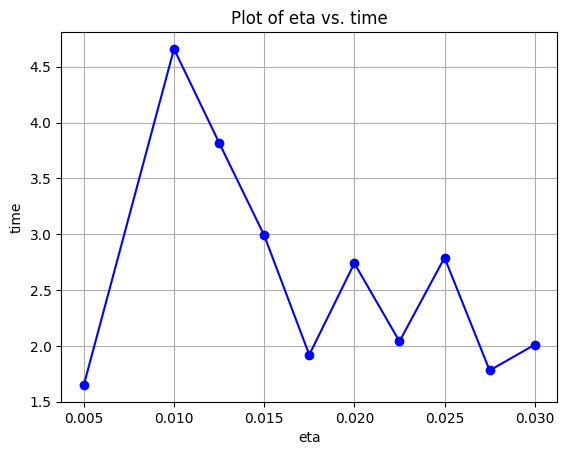

================================================== Empty Net ==================================================
ETA: 0.005 | 0.4 seconds | LogLoss: 0.6224 | AUC: 0.6989
ETA: 0.01 | 0.3 seconds | LogLoss: 0.6088 | AUC: 0.6951
ETA: 0.015 | 0.3 seconds | LogLoss: 0.6025 | AUC: 0.6955
ETA: 0.02 | 0.3 seconds | LogLoss: 0.5984 | AUC: 0.6930
ETA: 0.0225 | 0.3 seconds | LogLoss: 0.5982 | AUC: 0.6947
ETA: 0.025 | 0.4 seconds | LogLoss: 0.5905 | AUC: 0.6935
ETA: 0.0275 | 0.3 seconds | LogLoss: 0.5945 | AUC: 0.6953
ETA: 0.03 | 0.2 seconds | LogLoss: 0.5933 | AUC: 0.6951


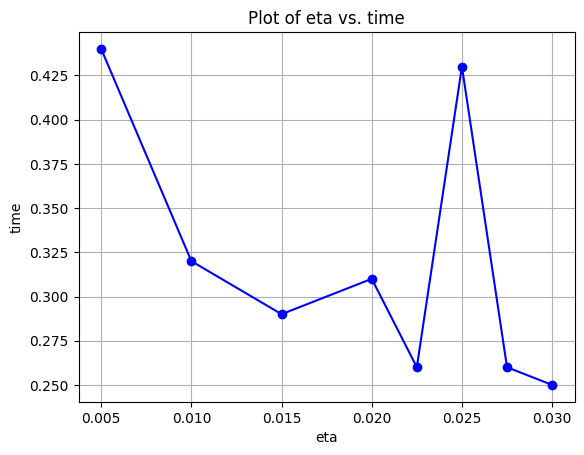

In [55]:
## Determing Quickest Learning Rates ##

# Get Learning Rate For Each Strength State #
ev_vec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] #[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.085, 0.1]
pp_vec = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.75, 1] #[0.01, 0.02, 0.03, 0.04 , 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
sh_vec = [0.005, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03] #[0.005, 0.075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.03, 0.04]
en_vec = [0.005, 0.01, 0.015, 0.02, 0.0225, 0.025, 0.0275, 0.03] #[0.02, 0.0225, 0.025, 0.0275, 0.03, 0.035, 0.04, 0.045, 0.05]

# Run
print('='*50, "Even Strength", "="*50)
get_fast_eta(dtrain = ev_dtrain, dvalid = ev_dvalid, eval_met = e_m, range_vec = ev_vec)
print('='*50, "Man-Advantage", "="*50)
get_fast_eta(dtrain = pp_dtrain, dvalid = pp_dvalid, eval_met = e_m, range_vec = pp_vec)
print('='*50, "Short-Handed", "="*50)
get_fast_eta(dtrain = sh_dtrain, dvalid = sh_dvalid, eval_met = e_m, range_vec = sh_vec)
print('='*50, "Empty Net", "="*50)
get_fast_eta(dtrain = en_dtrain, dvalid = en_dvalid, eval_met = e_m, range_vec = en_vec)

In [37]:
# Fixed Learning Rates (Time Optimized)
EV_eta = 0.3 # (16.5 seconds | LogLoss: 0.1959 | AUC: 0.7730)
PP_eta = 0.2 # (4.1 seconds | LogLoss: 0.2859 | AUC: 0.7062)
SH_eta = 0.01 # (1.8 seconds | LogLoss: 0.2259 | AUC: 0.8050)
EN_eta = 0.001 # (0.3 seconds | LogLoss: 0.6025 | AUC: 0.6955)

# Fixed Learning Rates (AUC Optimized)
#EV_eta = 0.04
#PP_eta = 0.03
#SH_eta = 0.02
#EN_eta = 0.01

In [67]:
def objective(trial, dtrain, dvalid, lr, eval_met = e_m):
    """ Using Optuna, I will take the fixed learning rate from above and use it to hypertune parameters related to trees (not boosting)"""

    base_params = {
    'objective': 'binary:logistic',
    'eval_metric': eval_met,
    'learning_rate': lr
    }

    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10, log=True)
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'valid-{eval_met}')
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0,
                      callbacks=[pruning_callback]
                      )
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score

[I 2024-02-05 15:27:51,362] A new study created in memory with name: no-name-afc0ab02-6c97-46c9-bc12-1ff054dd475f
[I 2024-02-05 15:28:01,372] Trial 0 finished with value: 0.7828880494845472 and parameters: {'tree_method': 'hist', 'max_depth': 7, 'min_child_weight': 2, 'max_delta_step': 10, 'subsample': 0.8364932101915348, 'colsample_bynode': 0.8251719279709269, 'reg_alpha': 9.61121037604149}. Best is trial 0 with value: 0.7828880494845472.
[I 2024-02-05 15:28:46,074] Trial 1 finished with value: 0.7823749391036553 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 8, 'max_delta_step': 2, 'subsample': 0.780027204616762, 'colsample_bynode': 0.561318754066814, 'reg_alpha': 3.953807603593903}. Best is trial 0 with value: 0.7828880494845472.
[I 2024-02-05 15:28:57,358] Trial 2 finished with value: 0.782447096394281 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 5, 'max_delta_step': 3, 'subsample': 0.7114885933939243, 'colsample_bynode'

================================================== Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate ==================================================
========================= HyperTuning Results For Fixed Learning Rate = 0.3
Best auc Score = 0.7835623145454478
Best Boosting Round: 34
========== Best Tree Params ==========
tree_method : hist
max_depth : 7
min_child_weight : 1
max_delta_step : 6
subsample : 0.8934742840415566
colsample_bynode : 0.9496291515607465
reg_alpha : 2.2463203019595763
 
================================================== Stage 2 - Boosting Parameters ==================================================
best scores (AUC , LOGLOSS) = (0.783623815199957, 0.19079499671656153)
boosting params ---------------------------
learning rate: 0.005
best boosting round: 2823
best scores (AUC , LOGLOSS) = (0.7835952422385071, 0.19075194003734167)
boosting params ---------------------------
learning rate: 0.01
best boosting round: 1461
best scores (AUC , LOGLOSS) = (0.

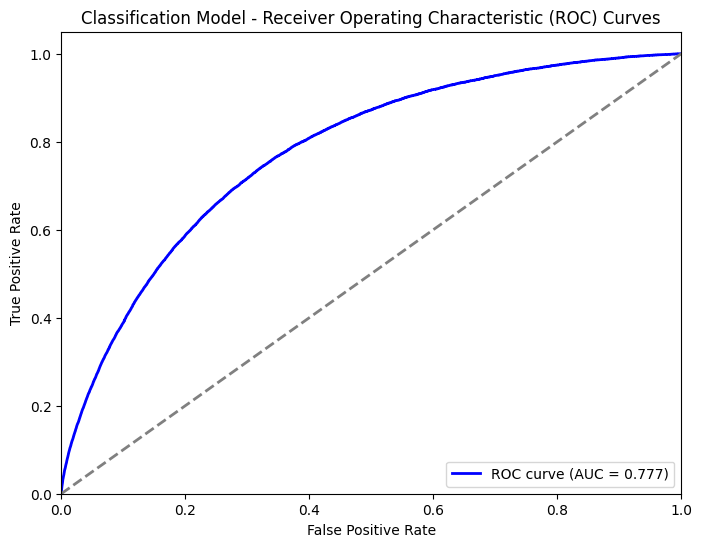

In [70]:
sampler = optuna.samplers.TPESampler(seed=71)
study = optuna.create_study(direction='maximize', sampler=sampler)
tic = time.time()
while time.time() - tic < 1200:
    study.optimize(lambda trial: objective(trial, dtrain = ev_dtrain, dvalid = ev_dvalid, lr = EV_eta), n_trials=1)

print('='*50,'Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate', '='*50)
print('='*25, f'HyperTuning Results For Fixed Learning Rate = {EV_eta}')
print(f'Best {e_m} Score = {study.best_trial.value}')
print(f'Best Boosting Round: {study.best_trial.user_attrs["best_iteration"]}')
print("="*10,'Best Tree Params',"="*10)
for k, v in study.best_trial.params.items():
    print(k, ':', v)

#### STAGE 2 ####
print(" ")
print('='*50, 'Stage 2 - Boosting Parameters', '='*50)
lr_list = []
auc_score_list = []
logloss_list = []
iterations_list = []
for i in [0.005, 0.01, 0.025, 0.05, 0.075, 0.1]:
    low_learning_rate = i
    params = {}
    params.update(study.best_trial.params)
    params['learning_rate'] = i
    model_stage2 = xgb.train(params=params, dtrain=ev_dtrain, 
                             num_boost_round=10000,
                             evals=[(ev_dtrain, 'train'), (ev_dvalid, 'valid')],
                             early_stopping_rounds=50,
                             verbose_eval=0)
    
    print(f'best scores (AUC , LOGLOSS) = {score_model(model_stage2, ev_dvalid)}')
    print('boosting params ---------------------------')
    print(f'learning rate: {params["learning_rate"]}')
    print(f'best boosting round: {model_stage2.best_iteration}')
    auc_score, ll_score = score_model(model_stage2, ev_dvalid)

    lr_list.append(i)
    auc_score_list.append(auc_score)
    logloss_list.append(ll_score)
    iterations_list.append(model_stage2.best_iteration)

lr_df = pd.DataFrame({
    'eta': lr_list,
    'auc': auc_score_list,
    'logloss': logloss_list,
    'itr': iterations_list
})
print(lr_df)

best_lr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['eta'].iloc[0] 
best_itr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['itr'].iloc[0] 

params['learning_rate'] = best_lr
ev_model_final = xgb.train(params=params, dtrain=ev_dtrainvalid, 
                        num_boost_round=best_itr,
                        verbose_eval=0)

print('Final Even Strength Model ==========================')
print(f'test score against old data (AUC, LOGLOSS) = {score_model(ev_model_final, ev_dtest)}')
print(f'test score against current data (AUC, LOGLOSS) = {score_model(ev_model_final, ev_dcurrent)}')
print(f'test score against all test data (AUC, LOGLOSS) = {score_model(ev_model_final, ev_dtestall)}')
print('parameters ---------------------------')
for k, v in params.items():
    print(k, ':', v)
print(f'num_boost_round: {best_itr}')
best_ev_params = params

analyize_model(ev_model_final, ev_dtestall)

In [38]:
sampler = optuna.samplers.TPESampler(seed=71)
study = optuna.create_study(direction='maximize', sampler=sampler)
tic = time.time()
while time.time() - tic < 150:
    study.optimize(lambda trial: objective(trial, dtrain = pp_dtrain, dvalid = pp_dvalid, lr = PP_eta), n_trials=1)

print('='*50,'Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate', '='*50)
print('='*25, f'HyperTuning Results For Fixed Learning Rate = {PP_eta}')
print(f'Best {e_m} Score = {study.best_trial.value}')
print(f'Best Boosting Round: {study.best_trial.user_attrs["best_iteration"]}')
print("="*10,'Best Tree Params',"="*10)
for k, v in study.best_trial.params.items():
    print(k, ':', v)

#### STAGE 2 ####
print(" ")
print('='*50, 'Stage 2 - Boosting Parameters', '='*50)
lr_list = []
auc_score_list = []
logloss_list = []
iterations_list = []
for i in [0.005, 0.01, 0.1]:
    low_learning_rate = i
    params = {}
    params.update(study.best_trial.params)
    params['learning_rate'] = i
    model_stage2 = xgb.train(params=params, dtrain=pp_dtrain, 
                             num_boost_round=10000,
                             evals=[(pp_dtrain, 'train'), (pp_dvalid, 'valid')],
                             early_stopping_rounds=50,
                             verbose_eval=0)
    
    print(f'best scores (AUC , LOGLOSS) = {score_model(model_stage2, pp_dvalid)}')
    print('boosting params ---------------------------')
    print(f'learning rate: {params["learning_rate"]}')
    print(f'best boosting round: {model_stage2.best_iteration}')
    auc_score, ll_score = score_model(model_stage2, pp_dvalid)

    lr_list.append(i)
    auc_score_list.append(auc_score)
    logloss_list.append(ll_score)
    iterations_list.append(model_stage2.best_iteration)

lr_df = pd.DataFrame({
    'eta': lr_list,
    'auc': auc_score_list,
    'logloss': logloss_list,
    'itr': iterations_list
})
print(lr_df)

best_lr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['eta'].iloc[0] 
best_itr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['itr'].iloc[0] 

params['learning_rate'] = best_lr
pp_model_final = xgb.train(params=params, dtrain=pp_dtrainvalid, 
                        num_boost_round=best_itr,
                        verbose_eval=0)

print('Final Even Strength Model ==========================')
print(f'test score against old data (AUC, LOGLOSS) = {score_model(pp_model_final, pp_dtest)}')
print(f'test score against current data (AUC, LOGLOSS) = {score_model(pp_model_final, pp_dcurrent)}')
print(f'test score against all test data (AUC, LOGLOSS) = {score_model(pp_model_final, pp_dtestall)}')
print('parameters ---------------------------')
for k, v in params.items():
    print(k, ':', v)
print(f'num_boost_round: {best_itr}')
best_pp_params = params
analyize_model(pp_model_final, pp_dtestall)

[I 2024-02-05 14:40:00,113] A new study created in memory with name: no-name-5a05cc2d-1f50-416f-ac44-974a505c2fbe
[I 2024-02-05 14:40:01,596] Trial 0 finished with value: 0.7068057913195862 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 2, 'max_delta_step': 10, 'subsample': 0.8364932101915348, 'colsample_bynode': 0.8613021421899187, 'reg_alpha': 9.61121037604149}. Best is trial 0 with value: 0.7068057913195862.
[I 2024-02-05 14:40:06,950] Trial 1 finished with value: 0.7074572644981334 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 8, 'max_delta_step': 2, 'subsample': 0.780027204616762, 'colsample_bynode': 0.5681319489631267, 'reg_alpha': 3.953807603593903}. Best is trial 1 with value: 0.7074572644981334.
[I 2024-02-05 14:40:08,382] Trial 2 finished with value: 0.7047164559895818 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 5, 'max_delta_step': 3, 'subsample': 0.7114885933939243, 'colsample_bynod

================================================== Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate ==================================================
========================= HyperTuning Results For Fixed Learning Rate = 0.2
Best auc Score = 0.7100390298514453
Best Boosting Round: 49
========== Best Tree Params ==========
tree_method : hist
max_depth : 6
min_child_weight : 3
max_delta_step : 3
subsample : 0.8747896906406675
colsample_bynode : 0.7597000613401274
reg_alpha : 1.7526637016282076
 
================================================== Stage 2 - Boosting Parameters ==================================================
best scores (AUC , LOGLOSS) = (0.7107375869663951, 0.282698202569894)
boosting params ---------------------------
learning rate: 0.005
best boosting round: 1412
best scores (AUC , LOGLOSS) = (0.7102839765123011, 0.28274515079752854)
boosting params ---------------------------
learning rate: 0.01
best boosting round: 771
best scores (AUC , LOGLOSS) = (0.70

In [71]:
sampler = optuna.samplers.TPESampler(seed=71)
study = optuna.create_study(direction='maximize', sampler=sampler)
tic = time.time()
while time.time() - tic < 120:
    study.optimize(lambda trial: objective(trial, dtrain = sh_dtrain, dvalid = sh_dvalid, lr = SH_eta), n_trials=1)

print('='*50,'Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate', '='*50)
print('='*25, f'HyperTuning Results For Fixed Learning Rate = {SH_eta}')
print(f'Best {e_m} Score = {study.best_trial.value}')
print(f'Best Boosting Round: {study.best_trial.user_attrs["best_iteration"]}')
print("="*10,'Best Tree Params',"="*10)
for k, v in study.best_trial.params.items():
    print(k, ':', v)

#### STAGE 2 ####
print(" ")
print('='*50, 'Stage 2 - Boosting Parameters', '='*50)
lr_list = []
auc_score_list = []
logloss_list = []
iterations_list = []
for i in [0.001, 0.005, 0.01, 0.1]:
    low_learning_rate = i
    params = {}
    params.update(study.best_trial.params)
    params['learning_rate'] = i
    model_stage2 = xgb.train(params=params, dtrain=sh_dtrain, 
                             num_boost_round=10000,
                             evals=[(sh_dtrain, 'train'), (sh_dvalid, 'valid')],
                             early_stopping_rounds=50,
                             verbose_eval=0)
    
    print(f'best scores (AUC , LOGLOSS) = {score_model(model_stage2, sh_dvalid)}')
    print('boosting params ---------------------------')
    print(f'learning rate: {params["learning_rate"]}')
    print(f'best boosting round: {model_stage2.best_iteration}')
    auc_score, ll_score = score_model(model_stage2, sh_dvalid)

    lr_list.append(i)
    auc_score_list.append(auc_score)
    logloss_list.append(ll_score)
    iterations_list.append(model_stage2.best_iteration)

lr_df = pd.DataFrame({
    'eta': lr_list,
    'auc': auc_score_list,
    'logloss': logloss_list,
    'itr': iterations_list
})
print(lr_df)

best_lr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['eta'].iloc[0] 
best_itr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['itr'].iloc[0] 

params['learning_rate'] = best_lr
sh_model_final = xgb.train(params=params, dtrain=sh_dtrainvalid, 
                        num_boost_round=best_itr,
                        verbose_eval=0)

print('Final Short-Handed Model ==========================')
print(f'test score against old data (AUC, LOGLOSS) = {score_model(sh_model_final, sh_dtest)}')
print(f'test score against current data (AUC, LOGLOSS) = {score_model(sh_model_final, sh_dcurrent)}')
print(f'test score against all test data (AUC, LOGLOSS) = {score_model(sh_model_final, sh_dtestall)}')
print('parameters ---------------------------')
for k, v in params.items():
    print(k, ':', v)
print(f'num_boost_round: {best_itr}')
best_sh_params = params
analyize_model(sh_model_final, sh_dtestall)

[I 2024-02-05 16:17:41,114] A new study created in memory with name: no-name-5dbb15f6-0e8a-491f-8554-32eab4ed8b57
[I 2024-02-05 16:17:42,894] Trial 0 finished with value: 0.7918597859275629 and parameters: {'tree_method': 'hist', 'max_depth': 7, 'min_child_weight': 2, 'max_delta_step': 10, 'subsample': 0.8364932101915348, 'colsample_bynode': 0.8251719279709269, 'reg_alpha': 9.61121037604149}. Best is trial 0 with value: 0.7918597859275629.
[I 2024-02-05 16:17:50,448] Trial 1 finished with value: 0.7961562062450446 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 8, 'max_delta_step': 2, 'subsample': 0.780027204616762, 'colsample_bynode': 0.561318754066814, 'reg_alpha': 3.953807603593903}. Best is trial 1 with value: 0.7961562062450446.
[I 2024-02-05 16:17:52,189] Trial 2 finished with value: 0.7932994821100221 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 5, 'max_delta_step': 3, 'subsample': 0.7114885933939243, 'colsample_bynode

================================================== Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate ==================================================
========================= HyperTuning Results For Fixed Learning Rate = 0.01
Best auc Score = 0.7980239629548407
Best Boosting Round: 763
========== Best Tree Params ==========
tree_method : approx
max_depth : 4
min_child_weight : 8
max_delta_step : 6
subsample : 0.727343585571938
colsample_bynode : 0.6529452071834326
reg_alpha : 1.5556269062020258
 
================================================== Stage 2 - Boosting Parameters ==================================================
best scores (AUC , LOGLOSS) = (0.7965853211086558, 0.21259258320058386)
boosting params ---------------------------
learning rate: 0.001
best boosting round: 3441
best scores (AUC , LOGLOSS) = (0.7963755081900842, 0.2126356946349445)
boosting params ---------------------------
learning rate: 0.005
best boosting round: 638
best scores (AUC , LOGLOSS) = 

[I 2024-02-05 16:21:19,738] A new study created in memory with name: no-name-abf92451-073d-48c8-8ef1-4bec532020de
[I 2024-02-05 16:21:20,073] Trial 0 finished with value: 0.6907087347074087 and parameters: {'tree_method': 'hist', 'max_depth': 7, 'min_child_weight': 2, 'max_delta_step': 10, 'subsample': 0.8364932101915348, 'colsample_bynode': 0.8251719279709269, 'reg_alpha': 9.61121037604149}. Best is trial 0 with value: 0.6907087347074087.
[I 2024-02-05 16:21:20,325] Trial 1 finished with value: 0.6909493997717666 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'min_child_weight': 8, 'max_delta_step': 2, 'subsample': 0.780027204616762, 'colsample_bynode': 0.561318754066814, 'reg_alpha': 3.953807603593903}. Best is trial 1 with value: 0.6909493997717666.
[I 2024-02-05 16:21:20,530] Trial 2 finished with value: 0.6922531350210701 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 5, 'max_delta_step': 3, 'subsample': 0.7114885933939243, 'colsample_bynode

================================================== Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate ==================================================
========================= HyperTuning Results For Fixed Learning Rate = 0.001
Best auc Score = 0.6973039137558413
Best Boosting Round: 3
========== Best Tree Params ==========
tree_method : approx
max_depth : 6
min_child_weight : 10
max_delta_step : 5
subsample : 0.7401460903411983
colsample_bynode : 0.9368421646800127
reg_alpha : 2.0673732730400087
 
================================================== Stage 2 - Boosting Parameters ==================================================
best scores (AUC , LOGLOSS) = (0.6919869690227406, 0.6194283600105226)
boosting params ---------------------------
learning rate: 0.0001
best boosting round: 9999
best scores (AUC , LOGLOSS) = (0.7055152144947309, 0.5973788016278736)
boosting params ---------------------------
learning rate: 0.001
best boosting round: 4885
best scores (AUC , LOGLOSS) 

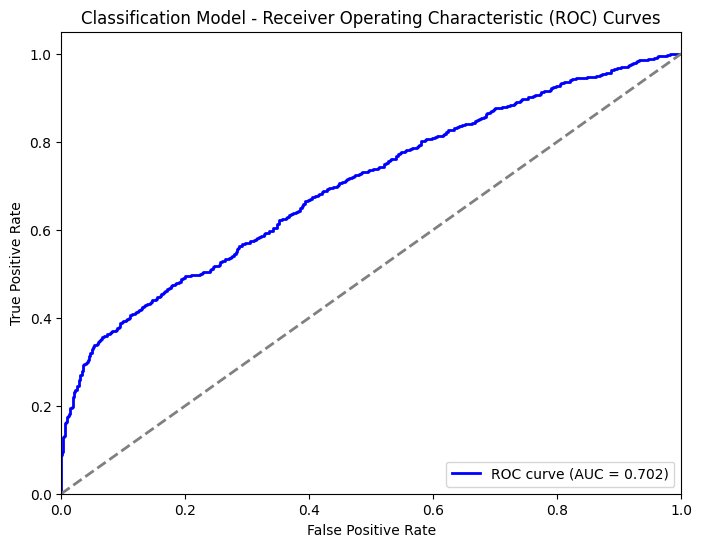

In [72]:
sampler = optuna.samplers.TPESampler(seed=71)
study = optuna.create_study(direction='maximize', sampler=sampler)
tic = time.time()
while time.time() - tic < 100:
    study.optimize(lambda trial: objective(trial, dtrain = en_dtrain, dvalid = en_dvalid, lr = EN_eta), n_trials=1)

print('='*50,'Stage 1 - Hypertune Tree Parameters at Fixed Learning Rate', '='*50)
print('='*25, f'HyperTuning Results For Fixed Learning Rate = {EN_eta}')
print(f'Best {e_m} Score = {study.best_trial.value}')
print(f'Best Boosting Round: {study.best_trial.user_attrs["best_iteration"]}')
print("="*10,'Best Tree Params',"="*10)
for k, v in study.best_trial.params.items():
    print(k, ':', v)

#### STAGE 2 ####
print(" ")
print('='*50, 'Stage 2 - Boosting Parameters', '='*50)
lr_list = []
auc_score_list = []
logloss_list = []
iterations_list = []
for i in [0.0001, 0.001, 0.005, 0.01, 0.1]:
    low_learning_rate = i
    params = {}
    params.update(study.best_trial.params)
    params['learning_rate'] = i
    model_stage2 = xgb.train(params=params, dtrain=en_dtrain, 
                             num_boost_round=10000,
                             evals=[(en_dtrain, 'train'), (en_dvalid, 'valid')],
                             early_stopping_rounds=50,
                             verbose_eval=0)
    
    print(f'best scores (AUC , LOGLOSS) = {score_model(model_stage2, en_dvalid)}')
    print('boosting params ---------------------------')
    print(f'learning rate: {params["learning_rate"]}')
    print(f'best boosting round: {model_stage2.best_iteration}')
    auc_score, ll_score = score_model(model_stage2, en_dvalid)

    lr_list.append(i)
    auc_score_list.append(auc_score)
    logloss_list.append(ll_score)
    iterations_list.append(model_stage2.best_iteration)

lr_df = pd.DataFrame({
    'eta': lr_list,
    'auc': auc_score_list,
    'logloss': logloss_list,
    'itr': iterations_list
})
print(lr_df)

best_lr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['eta'].iloc[0] 
best_itr = lr_df[lr_df['auc'] == lr_df['auc'].max()]['itr'].iloc[0] 

params['learning_rate'] = best_lr
en_model_final = xgb.train(params=params, dtrain=en_dtrainvalid, 
                        num_boost_round=best_itr,
                        verbose_eval=0)

print('Final Empty Net Model ==========================')
print(f'test score against old data (AUC, LOGLOSS) = {score_model(en_model_final, en_dtest)}')
print(f'test score against current data (AUC, LOGLOSS) = {score_model(en_model_final, en_dcurrent)}')
print(f'test score against current data (AUC, LOGLOSS) = {score_model(en_model_final, en_dtestall)}')
print('parameters ---------------------------')
for k, v in params.items():
    print(k, ':', v)
print(f'num_boost_round: {best_itr}')
best_en_params = params
analyize_model(en_model_final, en_dtestall)

### Save Models

In [25]:
import pickle

# EV
with open('Models/EvenStrength_xG_Model.pkl', 'wb') as file:
    pickle.dump(ev_model_final, file)

# PP
with open('Models/PowerPlay_xG_Model.pkl', 'wb') as file:
    pickle.dump(pp_model_final, file)

# SH
with open('Models/ShortHanded_xG_Model.pkl', 'wb') as file:
    pickle.dump(sh_model_final, file)

# EN
with open('Models/EmptyNet_xG_Model.pkl', 'wb') as file:
    pickle.dump(en_model_final, file)

In [17]:
# Load the model
with open('Models/EvenStrength_xG_Model.pkl', 'rb') as file:
    ev_model_final = pickle.load(file)

with open('Models/PowerPlay_xG_Model.pkl', 'rb') as file:
    pp_model_final = pickle.load(file)

with open('Models/ShortHanded_xG_Model.pkl', 'rb') as file:
    sh_model_final = pickle.load(file)

with open('Models/EmptyNet_xG_Model.pkl', 'rb') as file:
    en_model_final = pickle.load(file)

In [99]:
def slim_pbp(df):
    df = (
        df
        .select(['season', 'game_id', 'event_idx',
               'event_angle_change', 'event_angle_change_speed', 'seconds_since_last', 'distance_from_last',
               'puck_speed_since_last','pos_F','pos_D','pos_G','hand_R','hand_L',
               'event_team_shift_time_diff',
               'prior_shot_same','prior_miss_same','prior_block_same',
               'prior_shot_opp','prior_miss_opp','prior_block_opp',
               'prior_give_opp','prior_give_same','prior_take_opp','prior_take_same',
               'prior_hit_opp', 'prior_hit_same', 'prior_face_win', 'prior_face_lose',
               'off_wing', 'is_rebound', 'is_post_miss_shot', 'is_set_play', 'is_rush_play','is_fast_rush_play'])
        .filter(pl.col('season') == 20232024)
    )
    return df

BASE_DF = slim_pbp(EV_PBP)
for i in [PP_PBP, SH_PBP, EN_PBP]:
    BASE_DF = BASE_DF.extend(slim_pbp(i))

# Build Prediction Vectors
def make_prediction(model, cur_data): 
    pred = model.predict(data=cur_data, output_margin =True)
    probs = np.clip(pred, 0, 1)
    probs = pl.Series(probs)

    return probs


# Build Prediction DataFrame
prediction_df = pl.DataFrame({
    'season': pd.concat([ev_df, pp_df, sh_df, en_df])['season'],
    'game_id': pd.concat([ev_df, pp_df, sh_df, en_df])['game_id'],
    'event_idx': pd.concat([ev_df, pp_df, sh_df, en_df])['event_idx'],
    'xG': pl.concat([
        make_prediction(ev_model_final, ev_dcurrent),
        make_prediction(pp_model_final, pp_dcurrent),
        make_prediction(sh_model_final, sh_dcurrent),
        make_prediction(en_model_final, en_dcurrent)
    ])
}).sort(['season', 'game_id', 'event_idx'])

In [100]:
Current_PlayByPlay_DF = (
    CURRENT_DF
    .join(BASE_DF, on = ['season', 'game_id', 'event_idx'], how = 'inner')
    .join(prediction_df, on = ['season', 'game_id', 'event_idx'], how = 'inner')
)

Current_PlayByPlay_DF.head()

Current_PlayByPlay_DF.write_parquet('CurrentPBP_WithxG.parquet')

In [106]:
Current_PlayByPlay_DF['xG'].median()

0.046985745429992676

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


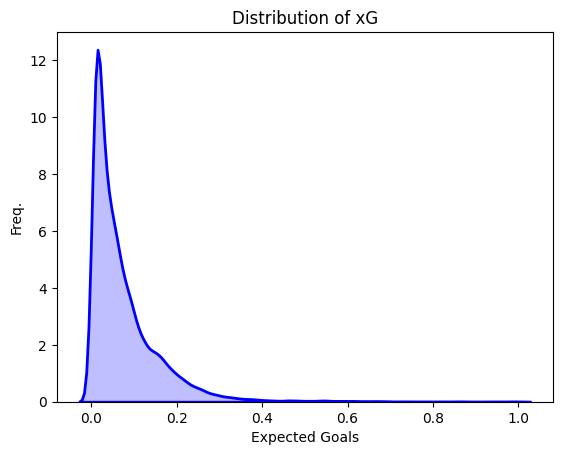

In [107]:
import seaborn as sns
# Plot xG Distribution
plot_df = pl.DataFrame(Current_PlayByPlay_DF['xG']).to_pandas()

sns.kdeplot(data=plot_df, x='xG', fill=True, linewidth=2, color='blue')
#plot_df.plot.density("xG", bins = 100, edgecolor="black")
plt.xlabel("Expected Goals")
plt.ylabel("Freq.")
plt.title("Distribution of xG")
plt.show()

In [ ]:
def analyize_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix):
    """
    Train and evaluate an XGBoost model.
    """

    # Load True and Predict 
    y_test = dmat.get_label() 
    y_pred = model.predict(dmat)

    r2 = r2_score(y_test, y_pred)
    lg_lss = log_loss(y_test, y_pred)
    f_fpr, f_tpr, f_thresholds = roc_curve(y_test, y_pred)
    f_roc_auc = auc(f_fpr, f_tpr)
    f_youdens_j = f_tpr - f_fpr
    f_optimal_threshold_index = np.argmax(f_youdens_j)
    f_optimal_threshold = f_thresholds[f_optimal_threshold_index]
    y_pred_binary = np.where(y_pred >= f_optimal_threshold, 1, 0)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    # Labels
    title_label = "Classification Model - Receiver Operating Characteristic (ROC) Curves"
    # Curves
    plt.plot(f_fpr, f_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {f_roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title_label)
    plt.legend(loc='lower right')

    print('XGBoost Classifier R2 on Test Data: %.3f' % np.round(r2, 2))
    print('XGBoost Classifier Log Loss on Test Data: %.3f' % np.round(lg_lss, 3))
    print('XGBoost Classifier AUC: %.3f' % np.round(f_roc_auc, 3))
    print('XGBoost Classifier Optimal Treshold: %.3f' % np.round(f_optimal_threshold, 3))


    print('Confusion Matrix:')
    print('-'* 17)
    print(confusion_matrix(y_test, y_pred_binary))
    print('='*53, '\n')
    print('Classification Report:')
    print('-'* 22)
    print(classification_report(y_test, y_pred_binary))

    plt.show()

def plot_top_features(model, n):
    # Get feature importance values for weight, gain, and cover
    weight_importance = model.get_booster().get_score(importance_type='weight')
    gain_importance = model.get_booster().get_score(importance_type='gain')
    cover_importance = model.get_booster().get_score(importance_type='cover')

    # Convert feature importance dictionaries to data frames
    weight_df = pd.DataFrame(weight_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
    gain_df = pd.DataFrame(gain_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
    cover_df = pd.DataFrame(cover_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)

    ## PLOT ##

    # Enable LaTex rendering
    plt.rcParams['text.usetex'] = False

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(16, 16))
    # Define data frames and titles for the subplots
    dfs = [weight_df, gain_df, cover_df]
    titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']
    subtitles = ["Weight importance represents the number of times a feature appears in a tree across all trees in the model",
                 "Gain importance represents the average gain of the feature when it's used in trees and measures the improvement in accuracy brought by a feature",
                 "Cover importance measures the relative quantity of observations concerned with a feature (i.e., the average coverage of the feature when it's used in trees)"]
    for i in range(3):
        # Create an axis for each subplot
        ax = axs[i]

        # Get the data frame and title for the current subplot
        df = dfs[i]
        title = 'Top '+ str(n) + ' Features - Importance Type: ' + titles[i]
        subtitle = subtitles[i]
        
        # Trim the feature names to 20 characters
        df['Feature'] = df['Feature'].str[:30]

        # Plot the bar chart for the current data frame
        ax.barh(df['Feature'], df['Score'], color='b', align='center')
        title_pad = 20  # Increase the pad value to add more space
        ax.set_title(title, pad=title_pad)
        ax.text(0.5, 1.02, subtitle, fontsize=10, fontstyle = 'italic', verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
        ax.invert_yaxis()

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

In [ ]:
class HyperparameterOptimizer:
    """Optimizes hyperparameters using Optuna."""

    def __init__(self, n_startup_trials, n_trials):
        """
        Initialize the HyperparameterOptimizer.

        Parameters:
        - n_startup_trials (int): Number of initial trials for TPESampler.
        - n_trials (int): Total number of trials for optimization.
        """
        self.n_startup_trials = n_startup_trials
        self.n_trials = n_trials

    def optimize_hyperparameters(self, x_train, y_train, x_test, y_test, type):
        def objective(trial):

            # Set Max Depth:
            if type == 'EV':
                md = trial.suggest_int('max_depth', 4, 4)
                lr = trial.suggest_float('learning_rate', 0.030, 0.070)
                ne = trial.suggest_int('n_estimators', 600, 850)
                mcw = trial.suggest_int('min_child_weight', 1, 3)
                alph = trial.suggest_int('reg_alpha', 0, 7)
                lam = trial.suggest_int('reg_lambda', 0, 7)
                gam = trial.suggest_float('gamma', .015, .025)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 3, 7)
            elif type == 'PP':
                md = trial.suggest_int('max_depth', 5, 5)
                lr = trial.suggest_float('learning_rate', 0.014, 0.0165)
                ne = trial.suggest_int('n_estimators', 550, 750)
                mcw = trial.suggest_int('min_child_weight', 2, 5)
                alph = trial.suggest_int('reg_alpha', 0, 4)
                lam = trial.suggest_int('reg_lambda', 0, 4)
                gam = trial.suggest_float('gamma', .004, .03)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 0, 5)
            elif type == 'SH':
                md = trial.suggest_int('max_depth', 4, 4)
                lr = trial.suggest_float('learning_rate', 0.021, 0.024)
                ne = trial.suggest_int('n_estimators', 350, 450)
                mcw = trial.suggest_int('min_child_weight', 0, 3)
                alph = trial.suggest_int('reg_alpha', 4, 6)
                lam = trial.suggest_int('reg_lambda', 0, 2)
                gam = trial.suggest_float('gamma', 0.008, 0.012)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 1, 4)
            elif type == 'EN':
                md = trial.suggest_int('max_depth', 2, 4)
                lr = trial.suggest_float('learning_rate', 0.02, 0.04)
                ne = trial.suggest_int('n_estimators', 300, 500)
                mcw = trial.suggest_float('min_child_weight', 0, 7)
                alph = trial.suggest_float('reg_alpha', 0, 2)
                lam = trial.suggest_float('reg_lambda', 0, 2)
                gam = trial.suggest_float('gamma', 0.00, 0.6)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 1, 3)
            else:
                md = trial.suggest_int('max_depth', 3, 9)
                lr = 0.3
                ne = trial.suggest_int('n_estimators', 300, 1000)
                mcw = trial.suggest_int('min_child_weight', 0, 7)
                alph = trial.suggest_int('reg_alpha', 0, 6)
                lam = trial.suggest_int('reg_lambda', 0, 6)
                gam = trial.suggest_float('gamma', 0.00, 0.6)
                sed = trial.suggest_int('seed', 87, 87)
                mds = trial.suggest_int('max_delta_step', 5, 5)

            param = {
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85),
                'gamma': gam,
                'max_depth': md,
                'learning_rate': lr,
                'min_child_weight': mcw,
                'reg_alpha': alph,
                'reg_lambda': lam,
                'subsample': trial.suggest_float('subsample', 0.8, 0.9),
                'n_estimators': ne,
                'max_delta_step': mds,
                'seed' : sed
            }
            model = xgb.XGBClassifier(**param)
            model.fit(x_train, y_train)
            y_pred = model.predict_proba(x_test)[:, 1]
            f_fpr, f_tpr, f_thresholds = roc_curve(y_test, y_pred)
            f_roc_auc = auc(f_fpr, f_tpr)
            logloss = log_loss(y_test, y_pred)
            return logloss
        
        study = optuna.create_study(direction='minimize', study_name='XGBoost Classification Optimization', 
                                    sampler=TPESampler(n_startup_trials=self.n_startup_trials))
        study.optimize(objective, n_trials=self.n_trials)

        print('Best', type,'hyperparameters: %s', study.best_params)
        return study.best_params, study.trials_dataframe()

class XGBoostTrainer:
    """Trains an XGBoost model and saves predictions."""

    def train_and_evaluate_xgboost(self, x_train, y_train, x_test, y_test, best_params):
        """
        Train and evaluate an XGBoost model.

        """
        if best_params == {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}:
            model_lab = "Baseline xGoal"
        else:
            model_lab = "Optimized xGoal"

        opt_xgb = xgb.XGBClassifier(**best_params)
        opt_xgb.fit(x_train, y_train)
        y_pred = opt_xgb.predict_proba(x_test)[:, 1]

        r2 = r2_score(y_test, y_pred)
        lg_lss = log_loss(y_test, y_pred)
        f_fpr, f_tpr, f_thresholds = roc_curve(y_test, y_pred)
        f_roc_auc = auc(f_fpr, f_tpr)
        f_youdens_j = f_tpr - f_fpr
        f_optimal_threshold_index = np.argmax(f_youdens_j)
        f_optimal_threshold = f_thresholds[f_optimal_threshold_index]
        y_pred_binary = np.where(y_pred >= f_optimal_threshold, 1, 0)

        # Plot ROC curves
        plt.figure(figsize=(8, 6))

        # Labels
        title_label = model_lab + " Model - Receiver Operating Characteristic (ROC) Curves"
        # Curves
        plt.plot(f_fpr, f_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {f_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title_label)
        plt.legend(loc='lower right')

        print(model_lab + ' XGBoost Classifier R2 on Test Data: %.3f' % np.round(r2, 2))
        print(model_lab + ' XGBoost Classifier Log Loss on Test Data: %.3f' % np.round(lg_lss, 3))
        print(model_lab + ' XGBoost Classifier AUC: %.3f' % np.round(f_roc_auc, 3))
        print(model_lab + ' XGBoost Classifier Optimal Treshold: %.3f' % np.round(f_optimal_threshold, 3))


        print('Confusion Matrix:')
        print('-'* 17)
        print(confusion_matrix(y_test, y_pred_binary))
        print('='*53, '\n')
        print('Classification Report:')
        print('-'* 22)
        print(classification_report(y_test, y_pred_binary))

        plt.show()

        return opt_xgb, y_pred, lg_lss, f_roc_auc, f_optimal_threshold

class Feature_Analysis:
    """Prints a plot showing the top features sorted by the 3 methods of evaluation"""

    def plot_top_features(self, model, n):
        # Get feature importance values for weight, gain, and cover
        weight_importance = model.get_booster().get_score(importance_type='weight')
        gain_importance = model.get_booster().get_score(importance_type='gain')
        cover_importance = model.get_booster().get_score(importance_type='cover')

        # Convert feature importance dictionaries to data frames
        weight_df = pd.DataFrame(weight_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
        gain_df = pd.DataFrame(gain_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)
        cover_df = pd.DataFrame(cover_importance.items(), columns=['Feature', 'Score']).sort_values(by='Score', ascending=False).head(n)

        ## PLOT ##

        # Enable LaTex rendering
        plt.rcParams['text.usetex'] = False

        # Create a figure with subplots
        fig, axs = plt.subplots(3, 1, figsize=(16, 16))
        # Define data frames and titles for the subplots
        dfs = [weight_df, gain_df, cover_df]
        titles = ['Weight Importance', 'Gain Importance', 'Cover Importance']
        subtitles = ["Weight importance represents the number of times a feature appears in a tree across all trees in the model",
                     "Gain importance represents the average gain of the feature when it's used in trees and measures the improvement in accuracy brought by a feature",
                     "Cover importance measures the relative quantity of observations concerned with a feature (i.e., the average coverage of the feature when it's used in trees)"]
        for i in range(3):
            # Create an axis for each subplot
            ax = axs[i]

            # Get the data frame and title for the current subplot
            df = dfs[i]
            title = 'Top '+ str(n) + ' Features - Importance Type: ' + titles[i]
            subtitle = subtitles[i]

            # Trim the feature names to 20 characters
            df['Feature'] = df['Feature'].str[:30]

            # Plot the bar chart for the current data frame
            ax.barh(df['Feature'], df['Score'], color='b', align='center')
            title_pad = 20  # Increase the pad value to add more space
            ax.set_title(title, pad=title_pad)
            ax.text(0.5, 1.02, subtitle, fontsize=10, fontstyle = 'italic', verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
            ax.invert_yaxis()

        # Adjust spacing between subplots
        plt.tight_layout()
        plt.show()


## *b) Convert Polars To Pandas + Clean Nulls*

I am chosing to convert my polars DF to pandas here as the code written in the function above deals with Pandas dataframes. This may be altered in the future to be compatable with a Polars dataframe but for now conversion from Polars to Pandas + cleaning a Pandas dataframe is performative enough to be able to do so.

In [ ]:
#= EV_PBP.filter(pl.col('pos_F').is_null()).select('event_player_1_id').unique()

In [ ]:
EV_PD = EV_PBP.to_pandas()
PP_PD = PP_PBP.to_pandas()
SH_PD = SH_PBP.to_pandas()
EN_PD = EN_PBP.to_pandas()

### *i) Check and Remove Nulls*  

In [ ]:
for df in [EV_PD, PP_PD, SH_PD, EN_PD]:
    # Get the count of null values in each column
    null_counts = df.isnull().sum()
    # Filter columns with count > 0
    filtered_columns = null_counts[null_counts > 0]
    # Show the filtered DataFrame
    print(filtered_columns)

In [ ]:
EV_PD.dropna(how = 'any', inplace = True)
PP_PD.dropna(how = 'any', inplace = True)
SH_PD.dropna(how = 'any', inplace = True)
EN_PD.dropna(how = 'any', inplace = True)

In [ ]:
# Calculate the correlation matrix
correlation_matrix = EV_PD.drop('event_idx', axis = 1).corr()

# Find the pairs of variables with their absolute correlations
correlation_pairs = []
threshold = 0.7  # Define your correlation threshold

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        corr_value = correlation_matrix.iloc[i, j]
        corr_abs_value = abs(corr_value)
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]

        # Change corr_value to "positive" or "negative"
        if corr_value > 0:
            corr_value_str = "Positive"
        elif corr_value < 0:
            corr_value_str = "Negative"
        else:
            corr_value_str = "None"

        correlation_pairs.append([var1, var2, corr_abs_value, corr_value_str])

# Create Result DF
Correlation_DF = pd.DataFrame(correlation_pairs, columns=['var1', 'var2', 'ABS_Corr_Val', 'Corr_Type'])


# Assuming 'var1' and 'var2' represent highly correlated columns
High_Corr_DF = Correlation_DF[Correlation_DF['ABS_Corr_Val'] > threshold]  # Filter based on correlation threshold
High_Corr_DF = High_Corr_DF.sort_values(by='ABS_Corr_Val', ascending=False)

#Goal Correlation
Goal_Corr_DF = Correlation_DF[(Correlation_DF['var1'] == 'is_goal') | (Correlation_DF['var2'] == 'is_goal')]

Goal_Corr_DF.sort_values(by='ABS_Corr_Val', ascending=False).head(10)

## Baseline Tests - Sample of Non-Current Year Data

### *Even Strength Model - True Sample*

In [ ]:
# Split the data into training and testing sets
ev_train_data = EV_PD[EV_PD['season'] != 20232024].sample(frac=0.8, random_state=87)
ev_test_data = EV_PD[EV_PD['season'] != 20232024].drop(ev_train_data.index)

# Define the features, target variable, and cols to exclude
ev_exclude_cols = ['season', 'game_id', 'event_idx']
ev_features = [t_col for t_col in EV_PD.columns if t_col not in ev_exclude_cols and t_col != "is_goal"]

ev_X_train, ev_y_train = ev_train_data[ev_features], ev_train_data["is_goal"]
ev_X_test, ev_y_test = ev_test_data[ev_features], ev_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1,
                   'gamma': 0.15,
                   'max_depth': 4,
                   'min_child_weight': 3,
                   'reg_alpha': 3,
                   'reg_lambda': 0,
                   'subsample': 1,
                   'learning_rate': 0.058,
                   'n_estimators': 700}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
ev_baseline_model_sample, ev_y_pred_sample, ev_logloss_sample, ev_auc_sample, ev_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, baseline_params)

## *Man-Advantage Model - True Sample*

In [ ]:
# Split the data into training and testing sets
pp_train_data = PP_PD[~PP_PD['season'].isin([20232024])].sample(frac=0.8, random_state=87)
pp_test_data = PP_PD[~PP_PD['season'].isin([20232024])].drop(pp_train_data.index)

# Define the features, target variable, and cols to exclude
pp_exclude_cols = ['season', 'game_id', 'event_idx']
pp_features = [t_col for t_col in PP_PD.columns if t_col not in pp_exclude_cols and t_col != "is_goal"]

pp_X_train, pp_y_train = pp_train_data[pp_features], pp_train_data["is_goal"]
pp_X_test, pp_y_test = pp_test_data[pp_features], pp_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
pp_baseline_model_sample, pp_y_pred_sample, pp_logloss_sample, pp_auc_sample, pp_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, baseline_params)

## *Short Handed Model - True Sample*

In [ ]:
# Split the data into training and testing sets
sh_train_data = SH_PD[SH_PD['season'] != 20232024].sample(frac=0.8, random_state=87)
sh_test_data = SH_PD[SH_PD['season'] != 20232024].drop(sh_train_data.index)

# Define the features, target variable, and cols to exclude
sh_exclude_cols = ['season', 'game_id', 'event_idx']
sh_features = [t_col for t_col in SH_PD.columns if t_col not in sh_exclude_cols and t_col != "is_goal"]

sh_X_train, sh_y_train = sh_train_data[sh_features], sh_train_data["is_goal"]
sh_X_test, sh_y_test = sh_test_data[sh_features], sh_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
sh_baseline_model_sample, sh_y_pred_sample, sh_logloss_sample, sh_auc_sample, sh_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, baseline_params)

## *Empty Net Model - True Sample*

In [ ]:
# Split the data into training and testing sets
en_train_data = EN_PD[EN_PD['season'] != 20232024].sample(frac=0.8, random_state=87)
en_test_data = EN_PD[EN_PD['season'] != 20232024].drop(en_train_data.index)

# Define the features, target variable, and cols to exclude
en_exclude_cols = ['season', 'game_id', 'event_idx']
en_features = [t_col for t_col in EN_PD.columns if t_col not in en_exclude_cols and t_col != "is_goal"]

en_X_train, en_y_train = en_train_data[en_features], en_train_data["is_goal"]
en_X_test, en_y_test = en_test_data[en_features], en_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
en_baseline_model_sample, en_y_pred_sample, en_logloss_sample, en_auc_sample, en_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(en_X_train, en_y_train, en_X_test, en_y_test, baseline_params)

## Hypertune Parameters

Here, I want to hypertune my parameters and use the most current data as the test rather than a sample. If hypertuning is able to help the model be more predictive on the most current data (rather than testing against a sample of data that includes 2012-2013 data), then it will likely be more predictive in the future.

In [ ]:
# Optimize hyperparameters
hyperparameter_optimizer = HyperparameterOptimizer(n_startup_trials=10000, n_trials=1000)
alt_hyperparameter_optimizer = HyperparameterOptimizer(n_startup_trials=10000, n_trials=100)

# EV - Max Depth = 4
print("Begin Even Strength Hypertuning")
ev_best_params, ev_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(ev_X_train, ev_y_train, ev_X_test, ev_y_test, type = 'EV')

# PP
print("Begin Man Advantage Hypertuning")
#pp_best_params, pp_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(pp_X_train, pp_y_train, pp_X_test, pp_y_test, type = 'PP')

# SH
print("Begin Shorthanded Hypertuning")
#sh_best_params, sh_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(sh_X_train, sh_y_train, sh_X_test, sh_y_test, type = 'SH')

# EN
print("Begin Empty Net Hypertuning")
#en_best_params, en_param_df = hyperparameter_optimizer.optimize_hyperparameters(en_X_train, en_y_train, en_X_test, en_y_test, type = 'EN')

In [ ]:
ev_param_df.sort_values('value').head(20)
#{'max_depth': 4, 'learning_rate': 0.03310457341378971, 'n_estimators': 324, 'min_child_weight': 0.9206244284355457, 'reg_alpha': 0, 'reg_lambda': 0, 'gamma': 0.505513194675373, 'seed': 87, 'max_delta_step': 3, 'colsample_bytree': 0.8, 'subsample': 0.8}
# 0.594411442774224
#ev_param_df.groupby('params_max_depth').mean('value').sort_values(['value'])
#en_param_df.groupby('params_max_delta_step').mean('value').sort_values(['value'])
#en_param_df[en_param_df['params_max_depth'].isin([2,3,4])].groupby(['params_reg_alpha','params_reg_lambda']).mean('value').sort_values(['value'])

In [ ]:
import seaborn as sns
# Plotting
df = ev_param_df[ev_param_df['params_max_depth'] == 4].sort_values(by='params_learning_rate')
plt.scatter(df['params_learning_rate'], df['value'], alpha=0.7)
sns.regplot(x='params_learning_rate', y='value', data=df, scatter=False, label='Lowess Smoothed Line')
plt.xlabel('params_learning_rate')
plt.ylabel('value')
plt.title('Line Chart of Value vs params_learning_rate')
plt.show()

## Optimized Even Strength Model

In [ ]:
# Train HyperTuned Model
xgboost_trainer = XGBoostTrainer()
best_ev_model, y_pred_ev, best_ev_logloss, best_ev_auc, best_ev_OT = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, ev_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_ev_model, 20)

## Optimized Man-Advantage Model

In [ ]:

#pp_best_params = {'max_depth': 5, 'learning_rate': 0.016415367992596373, 'n_estimators': 716, 'min_child_weight': 5, 'reg_alpha': 2, 'reg_lambda': 1, 'gamma': 0.027577027992315935, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8, 'subsample': 0.8}
# Train HyperTuned Model
best_pp_model, y_pred_pp, best_pp_logloss, best_pp_auc, best_pp_OT = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, pp_best_params)

# Return Feature Analysis Plot
print(f"Best Params: {pp_best_params}")
Feature_Analysis().plot_top_features(best_pp_model, 20)

## Optimized Short-Handed Model

In [ ]:
# Best Params #
#{'max_depth': 4, 'learning_rate': 0.02270896103337748, 'n_estimators': 411, 'min_child_weight': 2, 'reg_alpha': 4, 'reg_lambda': 0, 'gamma': 0.008800184988203343, 'seed': 87, 'max_delta_step': 3, 'colsample_bytree': 0.8, 'subsample': 0.8}

# Train HyperTuned Model
best_sh_model, y_pred_sh, best_sh_logloss, best_sh_auc, best_sh_OT = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, sh_best_params)

# Return Feature Analysis Plot
print(f"Best Params: {sh_best_params}")
Feature_Analysis().plot_top_features(best_sh_model, 20)

## Optimized Empty Net Model

In [ ]:
# Best Parameters (Hard-Code)
en_best_params = {'max_depth': 4, 'learning_rate': 0.03310457341378971, 'n_estimators': 324, 'min_child_weight': 0.9206244284355457, 'reg_alpha': 0, 'reg_lambda': 0, 'gamma': 0.505513194675373, 'seed': 87, 'max_delta_step': 3, 'colsample_bytree': 0.9, 'subsample': 0.9}

# Train HyperTuned Model
best_en_model, y_pred_en, best_en_logloss, best_en_auc, best_en_OT = xgboost_trainer.train_and_evaluate_xgboost(en_X_train, en_y_train, en_X_test, en_y_test, en_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_en_model, 20)

## Analyze Accuracy Metrics

In [ ]:
analysis_df = pd.DataFrame({
    'Strength_Type': ['EV', 'EV', 'PP', 'PP', 'SH', 'SH', 'EN', 'EN'],
    'Test_Type': ['Sample', 'Optimized','Sample', 'Optimized','Sample', 'Optimized','Sample', 'Optimized'],
    'Log_Loss': [ev_logloss_sample, best_ev_logloss, pp_logloss_sample, best_pp_logloss, sh_logloss_sample, best_sh_logloss, en_logloss_sample, best_en_logloss],
    'AUC': [ev_auc_sample, best_ev_auc,  pp_auc_sample, best_pp_auc, sh_auc_sample, best_sh_auc, en_auc_sample, best_en_auc],
    'Optimal_Threshold': [ev_OT_sample, best_ev_OT, pp_OT_sample, best_pp_OT, sh_OT_sample, best_sh_OT, en_OT_sample, best_en_OT],
})

print(analysis_df)

# 3) Apply Model

In [ ]:
# Filter Test Seasons
EV_DF = EV_PD[EV_PD['season'] > 2022]
PP_DF = PP_PD[PP_PD['season'] > 2022]
SH_DF = SH_PD[SH_PD['season'] > 2022]
EN_DF = EN_PD[EN_PD['season'] > 2022]

## Add xGoals and Model Type
#EV_DF['xG'] = y_pred_ev
#PP_DF['xG'] = y_pred_pp
#SH_DF['xG'] = y_pred_sh
#EN_DF['xG'] = y_pred_en
#
#EV_DF['model_type'] = pd.lit('EV')
#PP_DF['model_type'] = pd.lit('PP')
#SH_DF['model_type'] = pd.lit('SH')
#EN_DF['model_type'] = pd.lit('EN')

# Add xGoals and Model Type using assign
EV_DF = EV_DF.assign(xG=y_pred_ev, model_type='EV')
PP_DF = PP_DF.assign(xG=y_pred_pp, model_type='PP')
SH_DF = SH_DF.assign(xG=y_pred_sh, model_type='SH')
EN_DF = EN_DF.assign(xG=y_pred_en, model_type='EN', reb_angle_change=0.0, reb_angle_change_speed=0.0).astype({'reb_angle_change': 'float64', 'reb_angle_change_speed': 'float64'})

# Select Relevant Features
keep_cols = ['season', 'game_id', 'event_idx', 'model_type', 'xG', 'is_goal',
             'event_distance', 'event_angle', 'x_abs', 'y_abs',
             'is_set_play', 'is_rebound', 'event_angle_change', 'event_angle_change_speed',
             'off_wing', 'hand_R', 'hand_L', 'pos_F', 'pos_D', 'pos_G', 'prior_shot_same',
             'is_rush_play', 'seconds_since_last', 'puck_speed_since_last']
EV_DF = EV_DF[keep_cols]
PP_DF = PP_DF[keep_cols]
SH_DF = SH_DF[keep_cols]
EN_DF = EN_DF[keep_cols]


# To Polars
EV_DF = pl.DataFrame(EV_DF)
PP_DF = pl.DataFrame(PP_DF)
SH_DF = pl.DataFrame(SH_DF)
EN_DF = pl.DataFrame(EN_DF)

# Combine
df_list = [EV_DF, PP_DF, SH_DF, EN_DF]

PRED = df_list[0]
for df in df_list[1:]:
    PRED = PRED.extend(df)
print(str(PRED.height) + " Total Shots in Prediction DF")

PBP = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))
print("Max Date:", PBP['game_date'].str.to_date().max())

PBP_xG = PBP.join(PRED, on = ['season','game_id','event_idx'], how= "inner")

## Save Results and Analysis DF

In [ ]:
PBP_xG.head()
#PBP_xG['reb_angle_change_speed'].max()

## Network X Package

In [ ]:
import pathlib
xG_path = "FinalExpectedGoalsPredictions.parquet"
PBP_xG.write_parquet(
    xG_path,
    use_pyarrow=True,
)

#PBP_xG.write_arrow('FinalExpectedGoalsPredictions.csv')
analysis_df.to_csv('ModelAccuracyScores.csv')

In [ ]:
peek_cols = ["game_date", 'period', 'game_seconds',
             'home_abbreviation', 'away_abbreviation','home_score', 'away_score', 'model_type',
             'event_player_1_name', "event_type", "secondary_type", "shot_distance", "shot_angle", 'xG']

PBP_xG.filter((pl.col('event_type') == 'GOAL') & (pl.col('model_type') == 'EV')).sort('xG', descending=False).select(peek_cols).head()

## League Standings - Goal Differences

In [ ]:
# Pull Schedule

#PBP_xG.agg((pl.col('game_date').str.to_date().max()).alias('max_game_date'))
print(PBP_xG['game_date'].str.to_date().max())

In [ ]:
bet_teams = ['TOR', 'DET']
pythag_exp = 1.86

Def = (
    PBP_xG
    .with_columns((pl.when(pl.col('event_team_abbr') == pl.col('home_abbreviation'))
                     .then(pl.col('away_abbreviation'))
                     .otherwise(pl.col('home_abbreviation'))).alias('team'))
     .filter(((pl.col('season')==2024)) & (pl.col('season_type') == 'R') & (pl.col('model_type') != 'EN'))
     .groupby('team')
     .agg([
         (pl.col('xG').sum()).alias('xGoals_Against'),
         ((pl.when(pl.col('event_type') == 'GOAL')
             .then(pl.lit(1)).otherwise(pl.lit(0))).sum())
             .alias('Goals_Against')
          ])
     .with_columns((pl.col('Goals_Against') - pl.col('xGoals_Against')).alias('D_Diff_Over_Under'))
     .sort('xGoals_Against', descending = True)
)

Off = (
    PBP_xG
    .with_columns(pl.col('event_team_abbr').alias('team'))
    .filter(((pl.col('season')==2024)) & (pl.col('season_type') == 'R') & (pl.col('model_type') != 'EN'))
    .groupby('team')
    .agg([(pl.col('xG').sum()).alias('xGoals_For'),
          ((pl.when(pl.col('event_type') == 'GOAL')
              .then(pl.lit(1))
              .otherwise(pl.lit(0))).sum()).alias('Goals_For')
          ])
     .with_columns((pl.col('Goals_For') - pl.col('xGoals_For')).alias('O_Diff_Over_Under'))
     .sort('xGoals_For', descending = True)
)

NHL_Stats = (
    Off
    .join(Def, on = 'team', how = "inner")
    .with_columns([
    (pl.col('xGoals_For') - pl.col('xGoals_Against')).alias('xG_Difference'),
    (pl.col('Goals_For') - pl.col('Goals_Against')).alias('G_Difference')
     ])
     .with_columns(
         (pl.col('G_Difference') - (pl.col('xG_Difference') )).alias('Diff_Over_Under'),
         ((pl.col('xGoals_For').pow(pythag_exp)) / ((pl.col('xGoals_For').pow(pythag_exp)) + (pl.col('xGoals_Against').pow(pythag_exp)))).alias('xGWin_Pct'),
         ((pl.col('Goals_For').pow(pythag_exp)) / ((pl.col('Goals_For').pow(pythag_exp)) + (pl.col('Goals_Against').pow(pythag_exp)))).alias('GWin_Pct')
         )
     .sort('xGWin_Pct', descending=True)
)

NHL_Stats.head(32) #.filter(pl.col('team').is_in(bet_teams))

In [ ]:
import requests
# Variables
date_str = "2023-11-17"

# Create Predictions
sched_link = "https://api-web.nhle.com/v1/schedule/"+date_str
response = requests.get(sched_link)

# Parse the JSON content of the response
raw_data = pd.json_normalize(response.json())
sched_data = pd.json_normalize(raw_data['gameWeek'][0])

# Get Odds
odds_data = pd.json_normalize(raw_data['oddsPartners'][0])
US_Prov_ID = int(odds_data[odds_data['country'] == 'US']['partnerId'].iloc[0])
sched_data = pd.json_normalize(sched_data['games'][0])
game_df = sched_data[['id', 'season', 'gameState', 'awayTeam.abbrev', 'homeTeam.abbrev', 'homeTeam.odds', 'awayTeam.odds', 'gameCenterLink']]

In [ ]:
game_dfs = []
idx = 0

## Existing Game Odds
exist_id = [2023020251]
exist_home_odds = [ 165]
exist_away_odds = [-180]

exist_df = pd.DataFrame({
    'id': exist_id,
    'home_odds': exist_home_odds,
    'away_odds': exist_away_odds
})


for i in game_df['id']:

    raw_df = game_df[game_df['id'] == i]

    try:
        # Load Game Data
        home_odds_df = pd.json_normalize(raw_df['homeTeam.odds'][idx])
        away_odds_df = pd.json_normalize(raw_df['awayTeam.odds'][idx])

        home_odd = home_odds_df[home_odds_df['providerId'] == US_Prov_ID]['value'].iloc[0]
        away_odd = away_odds_df[away_odds_df['providerId'] == US_Prov_ID]['value'].iloc[0]

        df = raw_df[['id', 'season', 'awayTeam.abbrev', 'homeTeam.abbrev', 'gameState']]
        df = df.assign(home_odds=home_odd, away_odds=away_odd, game_date=date_str)

        game_dfs.append(df)

    except Exception as e:

        # Load Game Data
        df = raw_df[raw_df['id'] == i]

        home_odd = exist_df[exist_df['id'] == i]['home_odds'].iloc[0]
        away_odd = exist_df[exist_df['id'] == i]['away_odds'].iloc[0]

        df = raw_df[['id', 'season', 'awayTeam.abbrev', 'homeTeam.abbrev','gameState']]
        df = df.assign(home_odds=home_odd, away_odds=away_odd, game_date=date_str).astype({'home_odds': 'float64', 'away_odds': 'float64'})

        gme_lab = str(df['awayTeam.abbrev'].iloc[0])+ ' ('+ str(round(away_odd, 0)) + ') @ '+str(df['homeTeam.abbrev'].iloc[0]+ ' ('+ str(round(home_odd, 0)) + ')')

        print(f"{gme_lab} Has Already Started")

        game_dfs.append(df)

    # Move To Next Game
    idx += 1

# Concatenate all DataFrames in the game_dfs list into a single polarsDataFrame
result_df = pd.concat(game_dfs, ignore_index=True).astype({'home_odds': 'float64', 'away_odds': 'float64'})
result_df = pl.DataFrame(result_df)

In [ ]:
Bet_DF = (
    result_df
    .join(NHL_Stats.select([(pl.col(col).alias(f'away_{col}')) for col in NHL_Stats.columns]), left_on=['awayTeam.abbrev'], right_on=['away_team'])
    .join(NHL_Stats.select([(pl.col(col).alias(f'home_{col}')) for col in NHL_Stats.columns]), left_on=['homeTeam.abbrev'], right_on=['home_team'])
    .with_columns([
        ((pl.col('home_xGWin_Pct')) * (1 - pl.col('away_xGWin_Pct'))).alias('home_win'),
        ((pl.col('away_xGWin_Pct')) * (1 - pl.col('home_xGWin_Pct'))).alias('away_win'),
        (pl.when(pl.col('home_odds') < 0).then((-1*(pl.col('home_odds'))) / ((-1*(pl.col('home_odds')) + 100))).otherwise(100 / (pl.col('home_odds') + 100))).alias('home_imp_prob'),
        (pl.when(pl.col('away_odds') < 0).then((-1*(pl.col('away_odds'))) / ((-1*(pl.col('away_odds')) + 100))).otherwise(100 / (pl.col('away_odds') + 100))).alias('away_imp_prob')
    ])
    .with_columns([
        ((pl.col('home_win')) / (pl.col('home_win') + pl.col('away_win'))).alias('home_win'),
        ((pl.col('away_win')) / (pl.col('home_win') + pl.col('away_win'))).alias('away_win')
        
    ])
    .with_columns([
        (pl.col('home_win') - pl.col('home_imp_prob')).alias('home_xAdvantage'),
        (pl.col('away_win') - pl.col('away_imp_prob')).alias('away_xAdvantage')
    ])
    .with_columns([
        (pl.when(pl.col('home_xAdvantage') > pl.col('away_xAdvantage')).then(pl.col('home_xAdvantage')).otherwise(pl.col('away_xAdvantage'))).alias('Advantage'),
        (pl.when(pl.col('home_xAdvantage') > pl.col('away_xAdvantage')).then(pl.col('homeTeam.abbrev')).otherwise(pl.col('awayTeam.abbrev'))).alias('Bet_Team')
    ])
    .rename({"awayTeam.abbrev":"away_team", "homeTeam.abbrev":"home_team"})
    .select('id', "game_date", 'away_team', 'away_odds', 'away_imp_prob', 'away_win', 'home_team','home_odds', 'home_imp_prob', 'home_win', 'Bet_Team', 'Advantage')
)

Pretty_Bet_DF = (
    Bet_DF
    .select([
        pl.col("game_date").alias('Date'),
        pl.col("id").alias("Game ID"),
        pl.col("away_team").alias('Away Team'),
        pl.col('away_odds').round(0).alias('Away Odds'),
        pl.format("{}%", (pl.col('away_imp_prob')*100).round(2)).alias('Away ImpProb'),
        pl.format("{}%", (pl.col('away_win')*100).round(2)).alias('Away ExpWin'),
        pl.col("home_team").alias('Home Team'),
        pl.col('home_odds').round(0).alias('Home Odds'),
        pl.format("{}%", (pl.col('home_imp_prob')*100).round(2)).alias('Home ImpProb'),
        pl.format("{}%", (pl.col('home_win')*100).round(2)).alias('Home ExpWin'),
        pl.col("Bet_Team").alias("Bet Team"),
        pl.col("Advantage").alias('AdvNum'),
    ])
    .with_columns(pl.format("{}%", (pl.col('AdvNum')*100).round(2)).alias('Advantage'))
    .sort("AdvNum", descending=True)
    .drop('AdvNum')
)


with pl.Config(tbl_formatting="ASCII_FULL", tbl_hide_column_data_types=True, tbl_hide_dataframe_shape=True) as cfg:
    cfg.set_tbl_width_chars(200)
    print(Pretty_Bet_DF)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.colormaps.register(cmap=newcmap)

    return newcmap



In [ ]:
EV_PBP.filter(pl.col('shot_distance') != pl.col('event_distance'))

In [ ]:
#tgt_player = 'Sidney.Crosby'
#
#plot_data = (
#    PBP_xG.filter((pl.col('x_fixed') > 26) & (pl.col('model_type') == 'EV'))
#    .with_columns(pl.when(pl.col("event_player_1_name") == tgt_player).then(pl.lit(tgt_player.replace(".", " "))).otherwise(pl.lit("NHL Average")).alias('Grouping'))
#    .with_columns([
#        pl.when(pl.col('event_type') == 'GOAL').then(pl.lit(1)).otherwise(pl.lit(0)).alias('Goals'),
#        pl.when(pl.col('event_type').is_in(['SHOT', "MISSED_SHOT"])).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Shots')
#    ])
#    .groupby("x_fixed", "y_fixed")
#    .agg([
#        (pl.col('xG').sum()).alias("NHL_xG_Pct"),
#        (((pl.col('Goals') == 1).sum()) ).alias("Ply_Shot_Pct")
#    ])
#    .with_columns([
#        ((pl.col("NHL_xG_Pct")) - (pl.col("Ply_Shot_Pct"))).alias("Shot_Pct_Diff")
#    ])
#    .select(["x_fixed", "y_fixed", "Shot_Pct_Diff"])
#    .to_pandas()
#)

plot_data = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))

plot_data = (
    plot_data
    .filter((pl.col('event_type').is_in(fenwick_events)))
    .filter(~((pl.col('x_fixed').is_null()) & (pl.col('y_fixed').is_null())))
    .filter((pl.col('event_team_type') == 'away') & (pl.col('period') == 2))
    .with_columns((pl.lit(1)).alias('is_shot'))
    .groupby("x_fixed", "y_fixed", 'period')
    .agg(pl.col('is_shot').sum().alias('shots'))
    .select('x_fixed', 'y_fixed', 'shots', 'period')
    .to_pandas()
)

print(plot_data.period.unique())

#plot_data = (
#    EV_PBP
#    .select('x_fixed', 'y_fixed', 'is_goal')
#    .groupby("x_fixed", "y_fixed")
#    .agg(pl.col('is_goal').count().alias('shots'))
#    .to_pandas()
#)


plot_data.dropna(inplace = True)
plot_data.head()

rink = NHLRink(rotation=270, net={"visible": False})

## Define the axis limits
x_min, x_max = -100, 100
y_min, y_max = -42.5, 42.5

#shrunk_cmap = shiftedColorMap(matplotlib.cm.RdYlGn, start=plot_data['Shot_Pct_Diff'].min(), midpoint=0, stop=plot_data['Shot_Pct_Diff'].max(), name = 'NHL Total2')


# Create a custom colormap
colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # Red to white to green
n_bins = 256
cmap_name = "custom"
#cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Modify the colormap to make 0 white
#cmap(np.linspace(0, 1, n_bins))
#cmap.set_bad('white')



## Create a heatmap
plt.figure(figsize=(14, 10))

hb = plt.hexbin(plot_data['x_fixed'], plot_data['y_fixed'], C=plot_data['shots'], gridsize=500, cmap="bwr", extent=(plot_data['x_fixed'].min(), plot_data['x_fixed'].max(), plot_data['y_fixed'].min(), plot_data['y_fixed'].max()))
cbar = plt.colorbar(hb)
cbar.set_label('Shot_Pct_Diff')

# Set the axis limits
plt.xlim(x_min, x_max)
print("X Min and Max: ", x_min, x_max)
plt.ylim(y_min, y_max)
print("Y Min and Max: ", y_min, y_max)

# Add labels and title
plt.xlabel('X_Coord')
plt.ylabel('Y_Coord')
plt.title('2022-2024 NHL Expected Goals by Shot Location')

# Show the plot
plt.show()

In [ ]:
del shrunk_cmap

In [ ]:
from hockey_rink import NHLRink

# Set Up Data
plot_data = (
    PBP_xG
    .filter(
        (pl.col('model_type') == 'EV')
    )
).to_pandas()

fig = plt.plot(figsize=(28,16))
rink = NHLRink(rotation=0)
rink.draw(display_range="ozone")

contour_img = rink.contourf(plot_data.x_abs, plot_data.y_abs, values=plot_data.xG, cmap="bwr", 
                            plot_range="ozone", binsize=10, levels=50, statistic="mean")
plt.colorbar(contour_img, orientation="horizontal")

In [ ]:
PBP_xG.filter(
        (pl.col('model_type') == 'EV') &
        (pl.col('event_team_abbr') == 'PIT') &
        (pl.col('x_abs') > 89) &
        (pl.col('is_goal') == 1)
    ).head()

In [ ]:
# Library
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image

# Needed for custom colour mapping!
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

# Target Player
full_name = 'Sidney Crosby'

# Load Data
filter_var = ''
plot_keep_cols = ['event_player_1_name', 'event_player_1_id', 'x_abs', 'y_abs', 'is_goal', 'secondary_tpye', 'is_rebound', '']

plot_data = (
    PBP_xG
    .filter()
)


# Color Map
c = mcolors.ColorConverter().to_rgb()
positive_cm = ListedColormap([c("#e1e5e5"),c("#d63b36")])
negative_cm = ListedColormap([c("#e1e5e5"),c("#d63b36")])

# Set Plot Variables
gridsize=30;mincnt=0

# Player Data Creation


In [ ]:
test_raw = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))

In [ ]:
test_raw[['event_type', 'event_player_2_type']].groupby(['event_type', 'event_player_2_type']).agg(pl.col('event_type').count().alias('count'))

In [ ]:
test_raw.filter((pl.col('event_type') == 'GOAL') & (pl.col('empty_net') == True)).height

In [ ]:
test_raw.filter((pl.col('event_type') == 'MISSED_SHOT') & (pl.col('event_player_2_type') == 'Unknown')).select('event_player_1_id', 'event_player_1_type', 'event_player_2_id', 'event_player_2_type', 'event_goalie_id').head(20)

In [ ]:
test_raw.filter(~pl.col('empty_net').is_null())['event_type'].value_counts()